In [47]:
from pathlib import Path
import os

from utils import *

Config.FATIGUESET_AGG_DIRECTORY = os.path.join(DATA_DIRECTORY, 'fatigueset_hrv_data')
FATIGUESET_AGG_DIRECTORY = Config.FATIGUESET_AGG_DIRECTORY

import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import mixedlm, ols

from scipy.stats import mannwhitneyu, shapiro, pearsonr, mannwhitneyu, chi2_contingency, fisher_exact, barnard_exact, f_oneway

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

<hr>

# Brief Discussion of Study Protocol

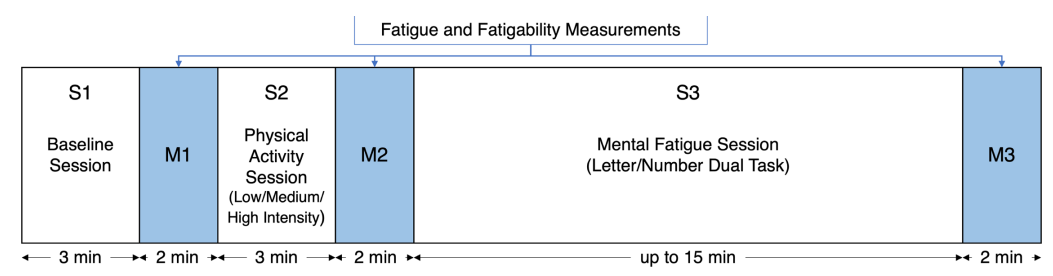

12 subjects were fitted with four wearable devices tracking 22 features at rates from 1 Hz to 256 Hz. 

Prototcol:
1. First, three minutes of baseline data is taken.
2. The first measurement period takes place, where subjects rate their physcical and mental fatigue on a scale from 0 to 100 and take two cognitive tests: Choice Reaction Time (crt) task and N-back Task.
3. Subjects go through three minutes of physical activity. The difference in intensity is the **only** difference between sessions. Subjects either walk, jog, or run.
4. Measurements are taken again.
5. Subjects go through at most 15 minutes of a mental fatigue inducing task. The task ends once 200 slides have been presented, which is why the time is variable.
   1. This period is only meant to induce fatigue, not obtain task metrics from.
6. Measurements are taken a final time.

Time series data is compiled into a dataframe with the index of Datetime and includes categorical columns for the Person and Session the data came from.
- For simplicity, the DateTime index is aggregated by second. This means that for features that track at a rate greater than 1 Hz, the mean of all datapoints in a given second was used as the value for that feature.

Metrics from the Measurement Periods, including self-reported physical and mental fatigue scores, as well as accuracy and response time on tasks, is compiled into another dataframe that has categorical columns for the Person and Session the data came from. The index is unimportant.



#### Note: The only difference between sessions is the type of physical activity done in the 3 minute Physical Activity Time Period. Other than that, the protocol is identical.

___

# Initialize Data

In [48]:
metadata = [
    'exp_markers.csv',
    'exp_fatigue.csv',
    'exp_crt.csv',
    'exp_nback.csv',
]


time_series_data = {
    'chest_physiology_summary' : 'chest',  
}

initialize_aggregated_data(metadata, time_series_data)

Session folder has already been renamed
Markers have already been renamed
Generated 01_metadata in c:\Users\639766\Documents\Internship\cognitive-fatigue-1\data\fatigueset_hrv_data
Generated 02_metadata in c:\Users\639766\Documents\Internship\cognitive-fatigue-1\data\fatigueset_hrv_data
Generated 03_metadata in c:\Users\639766\Documents\Internship\cognitive-fatigue-1\data\fatigueset_hrv_data
Generated 04_metadata in c:\Users\639766\Documents\Internship\cognitive-fatigue-1\data\fatigueset_hrv_data
Generated 05_metadata in c:\Users\639766\Documents\Internship\cognitive-fatigue-1\data\fatigueset_hrv_data
Generated 06_metadata in c:\Users\639766\Documents\Internship\cognitive-fatigue-1\data\fatigueset_hrv_data
Generated 07_metadata in c:\Users\639766\Documents\Internship\cognitive-fatigue-1\data\fatigueset_hrv_data
Generated 08_metadata in c:\Users\639766\Documents\Internship\cognitive-fatigue-1\data\fatigueset_hrv_data
Generated 09_metadata in c:\Users\639766\Documents\Internship\cognitiv

<hr>

# Preprocessing of Time Series Data:

Grabbing relevant data, cleaining, and interpolation of NaN values

In [49]:
df = get_stacked_person_csvs()

display(df)


print(
    df['chest_is_hrv_unreliable'].value_counts()
)
# Absolutely no data from bad-reads


df = df[['person', 'Session', 'chest_hrv']]

df

person Session  chest_hr  chest_br  chest_posture  \
DateTime                                                                
2021-09-02 09:08:19     01    high      61.0      16.0         -169.0   
2021-09-02 09:08:20     01    high      61.0      16.0         -169.0   
2021-09-02 09:08:21     01    high      60.0      16.0         -169.0   
2021-09-02 09:08:22     01    high      60.0      16.0         -169.0   
2021-09-02 09:08:23     01    high      61.0      16.0         -169.0   
...                    ...     ...       ...       ...            ...   
2021-09-09 16:33:54     12     low      77.0      19.0         -175.0   
2021-09-09 16:33:55     12     low      76.0      19.0         -175.0   
2021-09-09 16:33:56     12     low      75.0      19.0         -175.0   
2021-09-09 16:33:57     12     low      74.0      19.0         -175.0   
2021-09-09 16:33:58     12     low      73.0      19.0         -175.0   

                     chest_hr_confidence  chest_hrv  chest_is_hr_unreliable  \
DateTime                                                                      
2021-09-02 09:08:19                100.0       67.0                     0.0   
2021-09-02 09:08:20                100.0       67.0                     0.0   
2021-09-02 09:08:21                100.0       68.0                     0.0   
2021-09-02 09:08:22                100.0       68.0                     0.0   
2021-09-02 09:08:23                100.0       68.0                     0.0   
...                                  ...        ...                     ...   
2021-09-09 16:33:54                100.0       42.0                     0.0   
2021-09-09 16:33:55                100.0       42.0                     0.0   
2021-09-09 16:33:56                100.0       42.0                     0.0   
2021-09-09 16:33:57                100.0       42.0                     0.0   
2021-09-09 16:33:58                100.0       42.0                     0.0   

                     chest_is_br_unreliable  chest_is_hrv_unreliable  
DateTime                                                              
2021-09-02 09:08:19                     0.0                      0.0  
2021-09-02 09:08:20                     0.0                      0.0  
2021-09-02 09:08:21                     0.0                      0.0  
2021-09-02 09:08:22                     0.0                      0.0  
2021-09-02 09:08:23                     0.0                      0.0  
...                                     ...                      ...  
2021-09-09 16:33:54                     0.0                      0.0  
2021-09-09 16:33:55                     0.0                      0.0  
2021-09-09 16:33:56                     0.0                      0.0  
2021-09-09 16:33:57                     0.0                      0.0  
2021-09-09 16:33:58                     0.0                      0.0  

[45874 rows x 10 columns]

chest_is_hrv_unreliable
0.0    45874
Name: count, dtype: int64


person Session  chest_hrv
DateTime                                     
2021-09-02 09:08:19     01    high       67.0
2021-09-02 09:08:20     01    high       67.0
2021-09-02 09:08:21     01    high       68.0
2021-09-02 09:08:22     01    high       68.0
2021-09-02 09:08:23     01    high       68.0
...                    ...     ...        ...
2021-09-09 16:33:54     12     low       42.0
2021-09-09 16:33:55     12     low       42.0
2021-09-09 16:33:56     12     low       42.0
2021-09-09 16:33:57     12     low       42.0
2021-09-09 16:33:58     12     low       42.0

[45874 rows x 3 columns]

In [50]:
print(df.isnull().sum())

person          0
Session         0
chest_hrv    2455
dtype: int64


<hr>

# Interpolate 2 Types of NaN Values:

For gaps in the middle of a session, linear interpolation was used.

For gaps at the beginning or end of a session, gaps were replaced with the closest value (ffill, bfill).

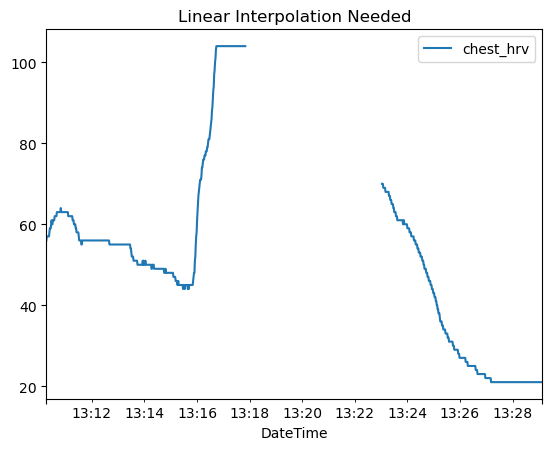

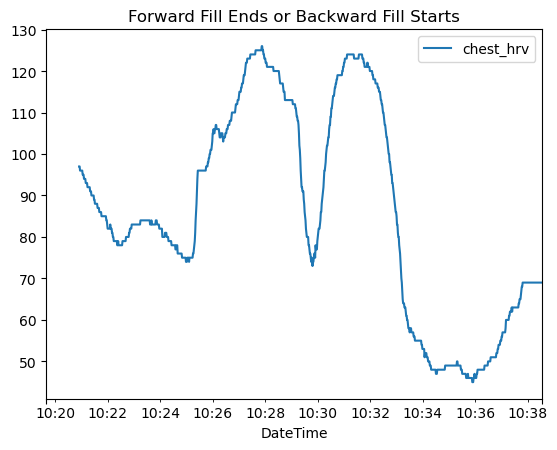

In [51]:

df[(df['person'] == '05') & (df['Session'] == 'high')].plot(title='Linear Interpolation Needed')

df[(df['person'] == '03') & (df['Session'] == 'low')].plot(title='Forward Fill Ends or Backward Fill Starts')

None

In [52]:
interpolated_df = completely_interpolate(df)

interpolated_df = attach_period_column(interpolated_df)

print('\n11 rows do not have an assigned period, can safely remove as it is')
print('due to rounding of datetime indexer and only removes one second of time.\n')

print('\nbefore dropping nulls:')
print(interpolated_df.isnull().sum())
# nulls in period are due to rounding of datetime indexer, 
# Can safely remove, as it is only one second per period
interpolated_df = interpolated_df.dropna()

print('\nafter dropping nulls:\n')

print(interpolated_df.isnull().sum(), '\n')

print('Final Interpolated DataFrame:\n')


display(interpolated_df)


11 rows do not have an assigned period, can safely remove as it is
due to rounding of datetime indexer and only removes one second of time.


before dropping nulls:
person        0
Session       0
period       11
chest_hrv     0
dtype: int64

after dropping nulls:

person       0
Session      0
period       0
chest_hrv    0
dtype: int64 

Final Interpolated DataFrame:



person Session        period  chest_hrv
DateTime                                                   
2021-09-02 09:08:19     01    high      baseline       67.0
2021-09-02 09:08:20     01    high      baseline       67.0
2021-09-02 09:08:21     01    high      baseline       68.0
2021-09-02 09:08:22     01    high      baseline       68.0
2021-09-02 09:08:23     01    high      baseline       68.0
...                    ...     ...           ...        ...
2021-09-09 16:33:54     12     low  measurement3       42.0
2021-09-09 16:33:55     12     low  measurement3       42.0
2021-09-09 16:33:56     12     low  measurement3       42.0
2021-09-09 16:33:57     12     low  measurement3       42.0
2021-09-09 16:33:58     12     low  measurement3       42.0

[45863 rows x 4 columns]

## Wrap preprocessing into a function:

In [53]:
interpolated_df = obtain_interpolated_df()

interpolated_df

person Session        period  chest_hrv
DateTime                                                   
2021-09-02 09:08:19     01    high      baseline       67.0
2021-09-02 09:08:20     01    high      baseline       67.0
2021-09-02 09:08:21     01    high      baseline       68.0
2021-09-02 09:08:22     01    high      baseline       68.0
2021-09-02 09:08:23     01    high      baseline       68.0
...                    ...     ...           ...        ...
2021-09-09 16:33:54     12     low  measurement3       42.0
2021-09-09 16:33:55     12     low  measurement3       42.0
2021-09-09 16:33:56     12     low  measurement3       42.0
2021-09-09 16:33:57     12     low  measurement3       42.0
2021-09-09 16:33:58     12     low  measurement3       42.0

[45863 rows x 4 columns]

<hr>

# Begin Heart Rate Variability (HRV) Analysis:

### Plot each person's HRV by sessions to get some main ideas:

#### **Legend:**

Green: Baseline Period

Yellow: Physical Activity Period

Red: Mental Activity Period

The title of each plot identifies the session type and self-reported mental fatigue after the baseline, physical activity, and mental activity periods respectively

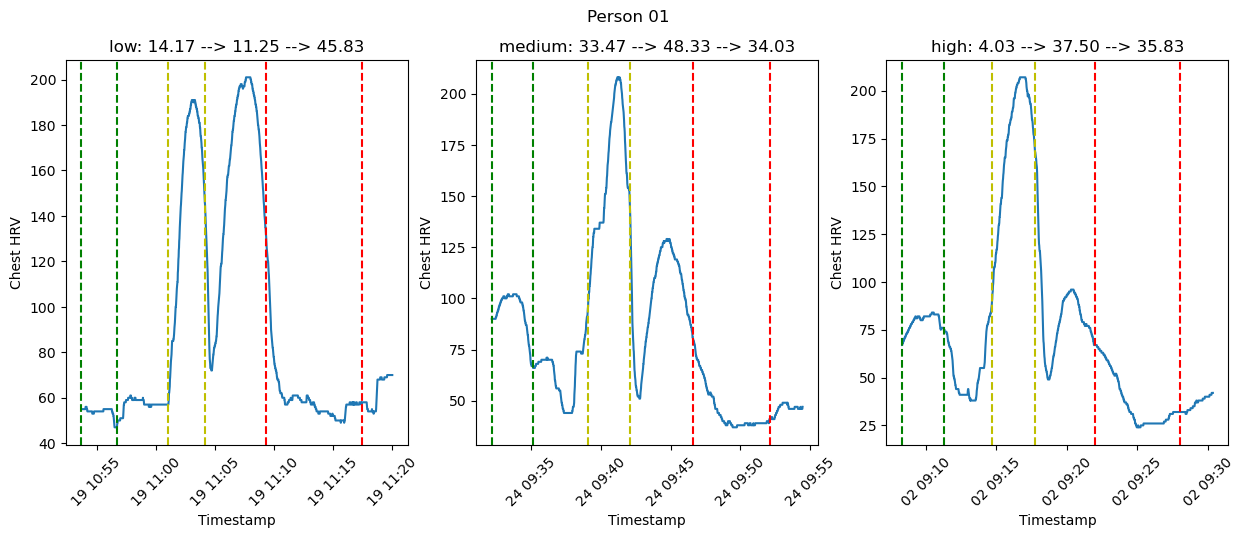

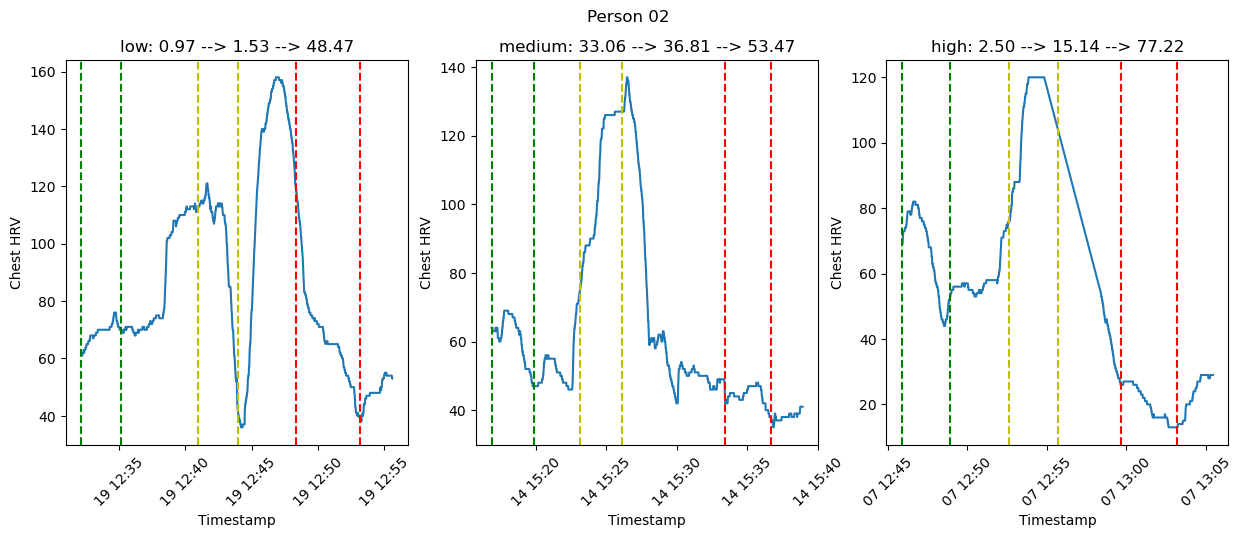

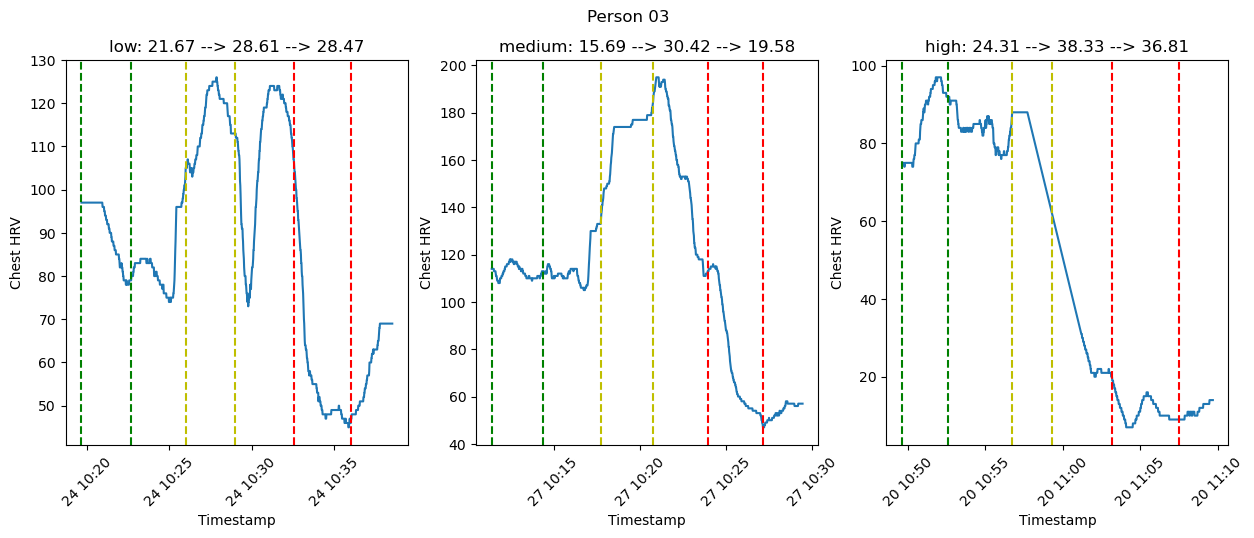

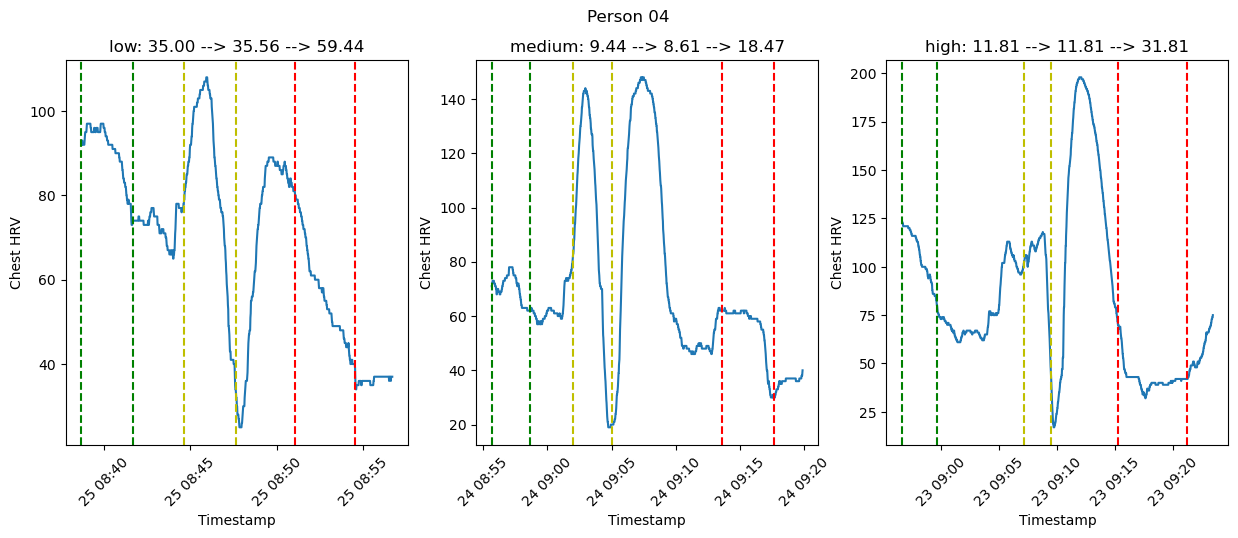

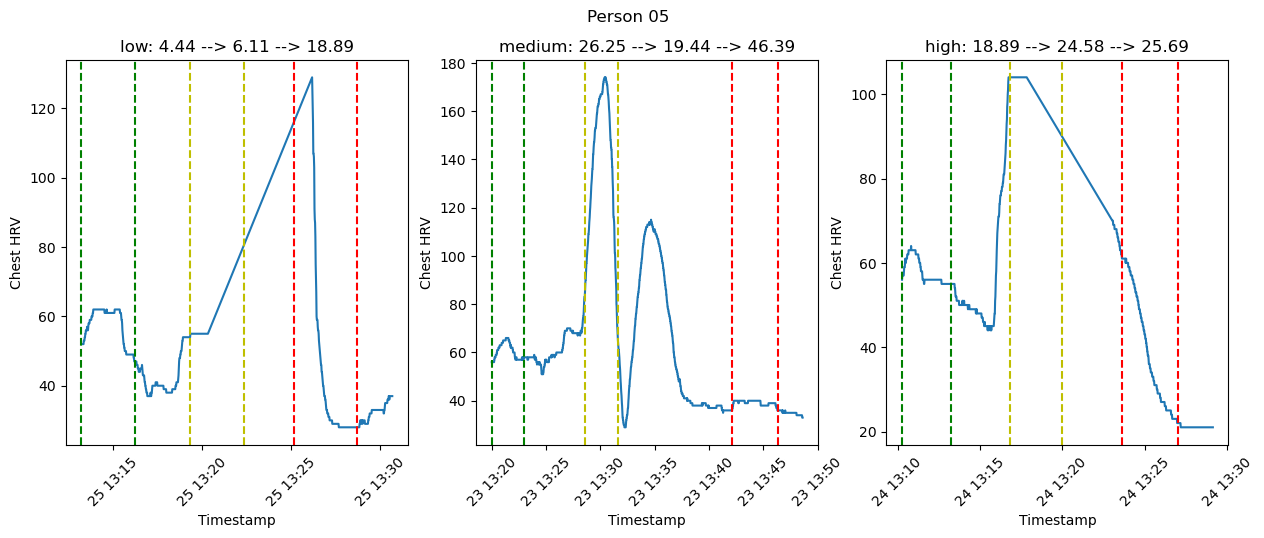

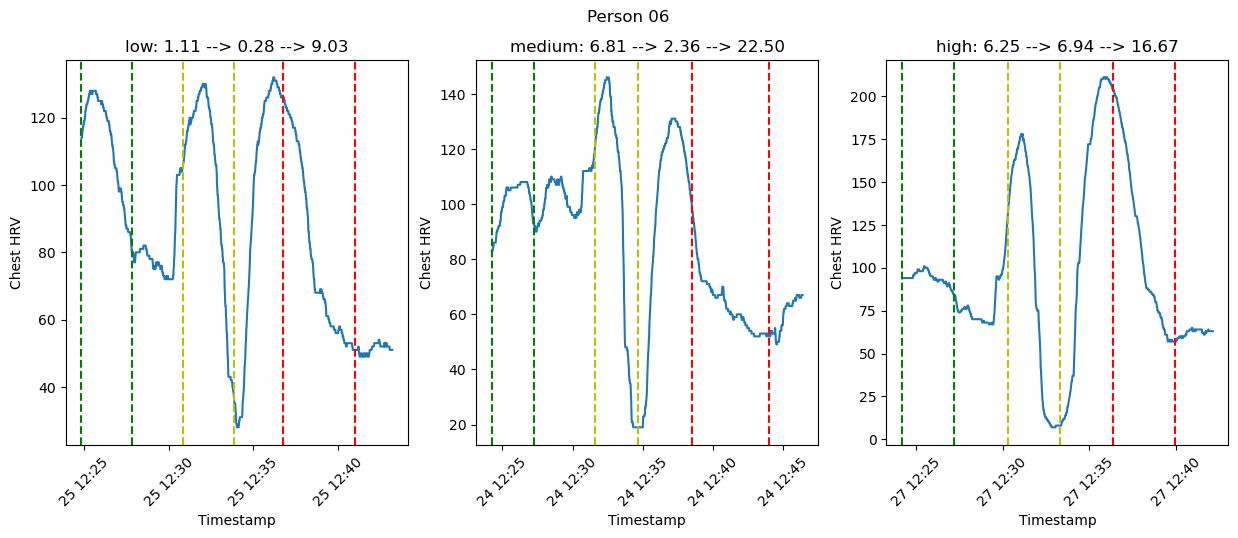

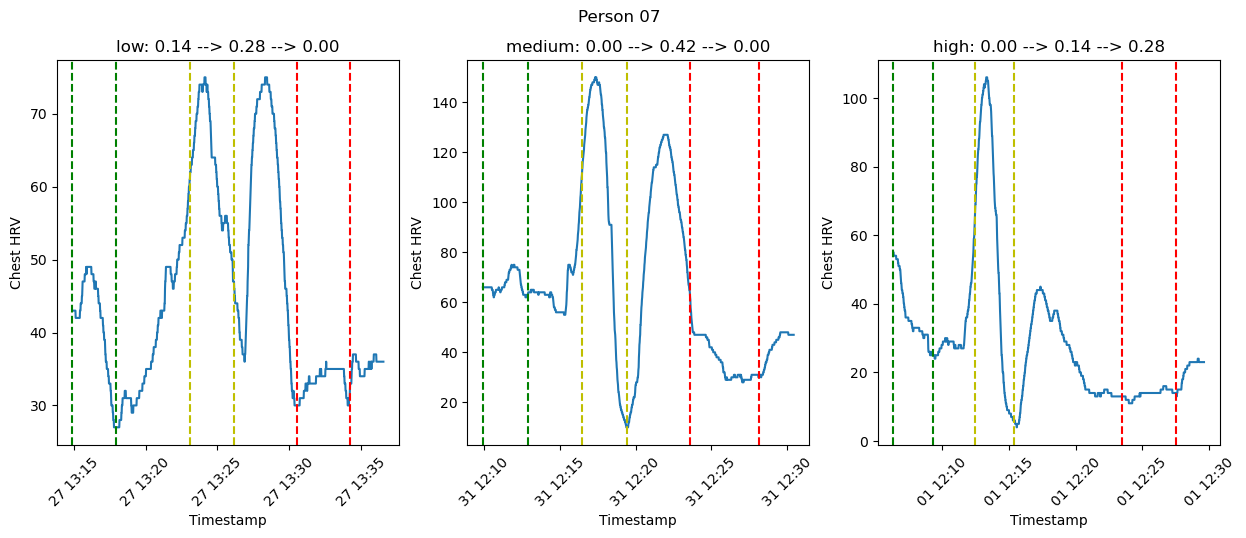

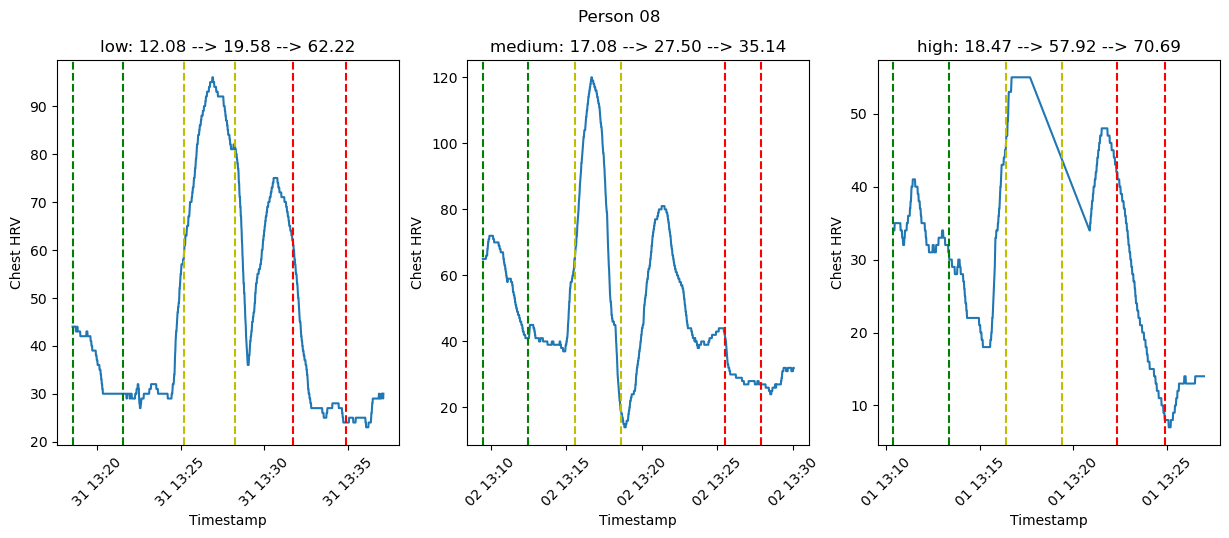

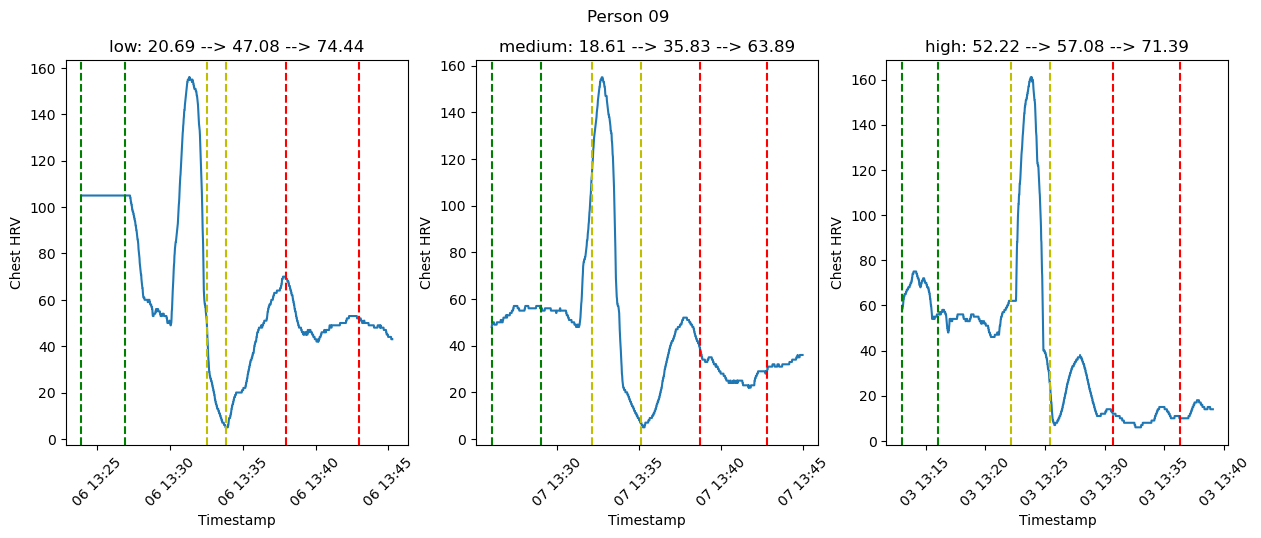

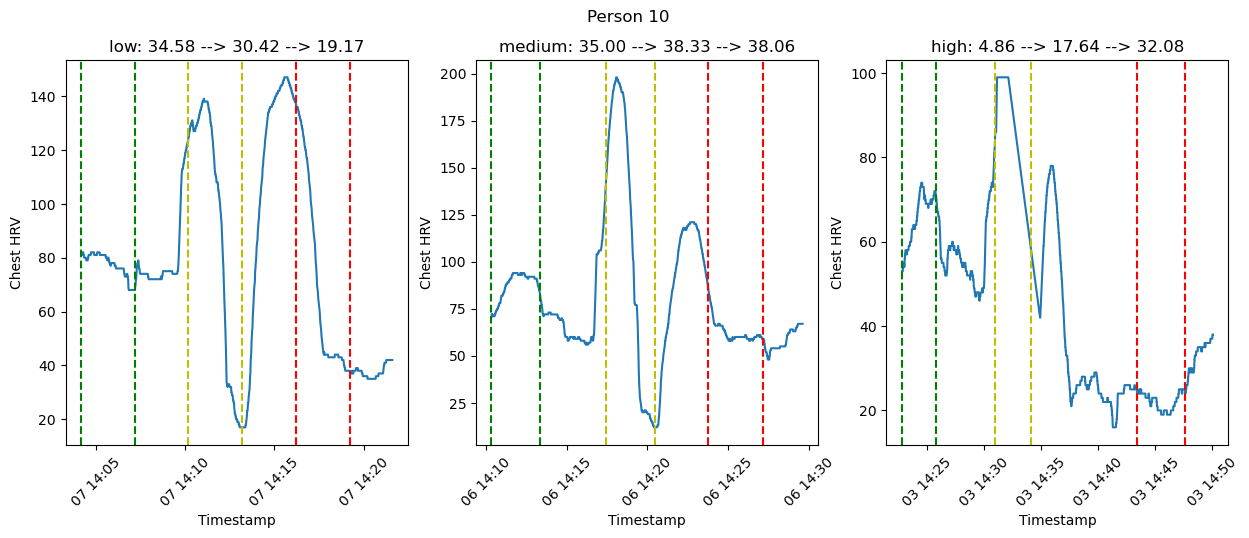

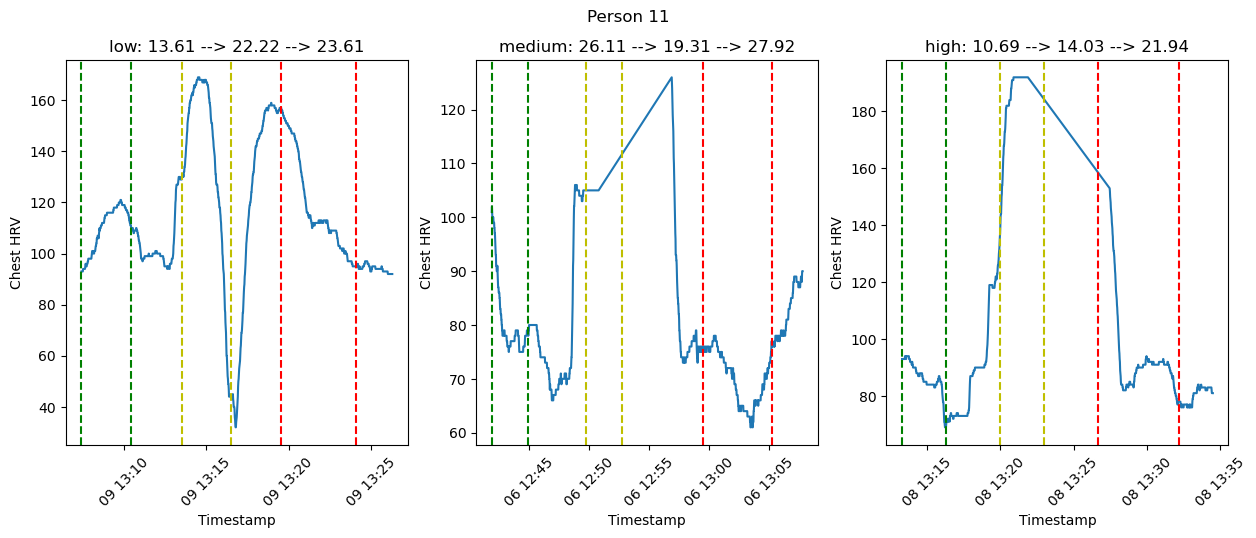

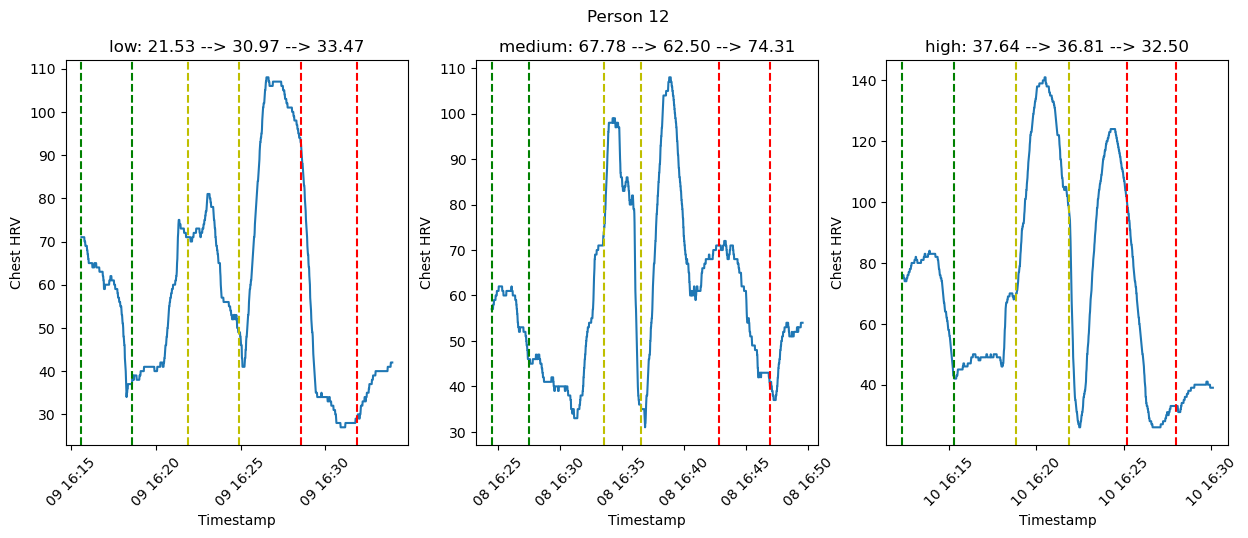

Empty DataFrame
Columns: []
Index: []

In [54]:
interpolated_df.groupby(['person'])[interpolated_df.columns].apply(sub, 'chest_hrv')

#### Trends I notice:
1. HRV is already increasing as you go into the physcial activity session
2. HRV reaches its maximum about halfway through physical activity and then plummets
3. Immedietly or a tiny bit after physical activity ends, HRV in Measurmenet Period 2 spikes almost as high as during physical activity, if not higher.
4. Decreases into and throughout mental fatigue inducing session, some have a camel hump on the way down
5. Increases either through the end of mental fatigue or right after

#### HRV spikes midway through physical activity period and measurement period 2

When people exercise, heart rate increases, but should remain relatively constant throughout exercise. 

HRV spikes midway through physical activity as heart rate increases. HRV decreases decreases as heart rate remains high during physical activity. When the physical activity ends, heart rate immedietly decreases, which is why HRV spikes again in the middle of the measurement period. HRV then decreases again as the body maintains a lower heart rate.

In a future study, each period should last a longer amount of time. I would want HRV in the physical activity period to spike and then decrease as the body maintains a consistent higher heart rate, and for the same to occur in the other measurement periods as well. This way, we can example the stark differences in features between when subjects are in specific periods and as they transition between periods.



<hr>

# Goal: Tell if / when a person returns to their baseline HRV

Print the HRV data of those that return to haseline HRV

person 01 session low was able to recover in 0 days 00:01:29


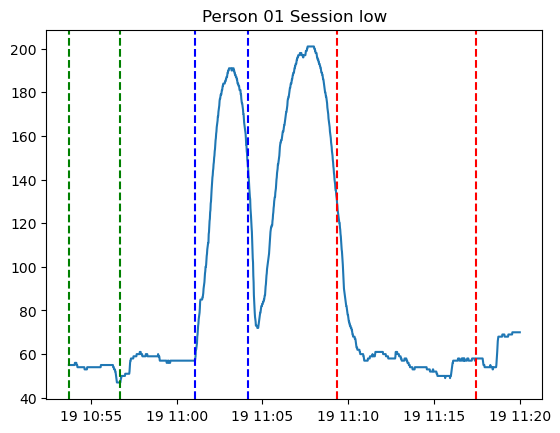

person 11 session medium was able to recover in 0 days 00:01:50


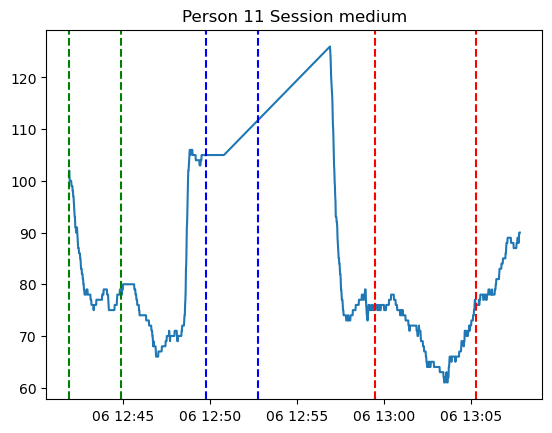

person 11 session high was able to recover in 0 days 00:00:30.501802


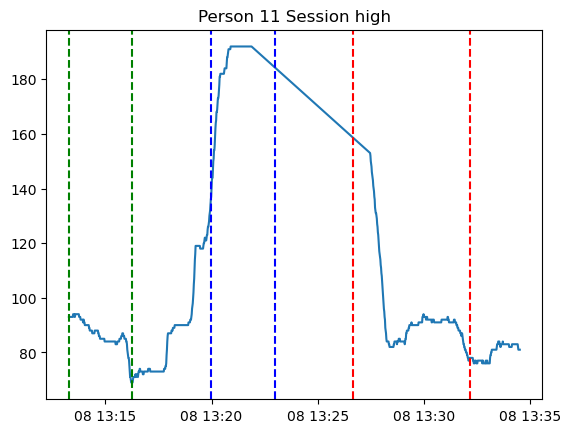

num recoveries: 3


In [55]:
interpolated_df = obtain_interpolated_df()

hrv = interpolated_df[['chest_hrv', 'person', 'Session']]

# get each person / session's baseline chest hrv mean
def get_baseline_hrv_per_person_and_session(hrv, person, session):
    start_baseline = get_time_of_event('start_baseline', person, session)
    end_baseline = get_time_of_event('end_baseline', person, session)

    baseline = hrv[(hrv.index >= start_baseline) & (hrv.index <= end_baseline)]['chest_hrv']

    baseline_mean = baseline.mean()

    baseline_std = baseline.std()

    return baseline_mean

# print(
#     get_baseline_hrv_per_person_and_session(hrv, '09', 'medium')
# )


def find_recovery_time(df, person, session):
    """Returns how long it took a person / session combo to get back to baseline hrv
    If return=None, then the person never recovered to baseline hrv"""

    baseline_mean = get_baseline_hrv_per_person_and_session(df, person, session)


    # Start a bit before the end of fatigue
    delta = np.timedelta64(1, 'm')
    end_fatigue = get_time_of_event('end_fatigue', person, session) - delta
    end_session = get_time_of_event('end_session', person, session)

    # Get the hrv data from the end of fatigue to the end of the session
    recovery = df[(hrv.index >= end_fatigue) & (hrv.index <= end_session)]['chest_hrv']
    
    # Use abs value to get into a threshold
    # Use a moving average to account for noise

    # Remember window is in seconds because data was aggregated to 1s
    recovery_rolling = recovery.rolling(window=15).mean()

    # Find the first time the rolling average goes above the baseline
    # df_of_hrvs_over_baseline = recovery_rolling[recovery_rolling > baseline_mean]
    df_of_hrvs_over_baseline = recovery_rolling[abs(recovery_rolling - baseline_mean) < 3]

    # print the first index of the first hrv over baseline
    try:
        recovery_instant = df_of_hrvs_over_baseline.index[0]
        time_to_recover = recovery_instant - end_fatigue
        return time_to_recover

    except:
        return None



# Plot and count full recoveries
total_recoveries = 0
for person in range(1, 13):
    for session in ['low', 'medium', 'high']:
        person, session = remap_person_and_session(person, session)
        r = find_recovery_time(hrv, person, session)
        if r is not None:
            total_recoveries += 1
            print(f'person {person} session {session} was able to recover in {r}')
            # plot hrv data
            plot(hrv[(hrv['person'] == person) & (hrv['Session'] == session)], 'chest_hrv')

print(f'num recoveries: {total_recoveries}')



# Conclusion

The three minute measurement period allowed only 3 subjects out of 36 to recover back to baseline HRV. The study protocol could be improved by increasing the Measurement periods time to allow enough time for all subjects to return to baseline HRV.

After examining the preliminary questionnaires' of the people who were able to return to baseline (`fatigueset/preliminary_questionnaire.xlsx`), there seems to be no correlation between any of their self-reports (self-reported general physical fitness, agility, flexibility...) and the fact that they were able to return to baseline while others did not.

### Along with the spikes in the middle of physical_activity and measurement period 2, this shows that the time periods are simply not long enough. If they were long enough, during both the physical activity and second measurement period, we would expect HRV to go to back down, as in phgsiucal activity, heart rate should consistently be higher and in the measurement period, heart should consistently be low.

___

## Plot mean HRV aggregated over all people for each session:

Mean of each person / Session / period is added as a column for ease of access, then aggregated by session and plotted

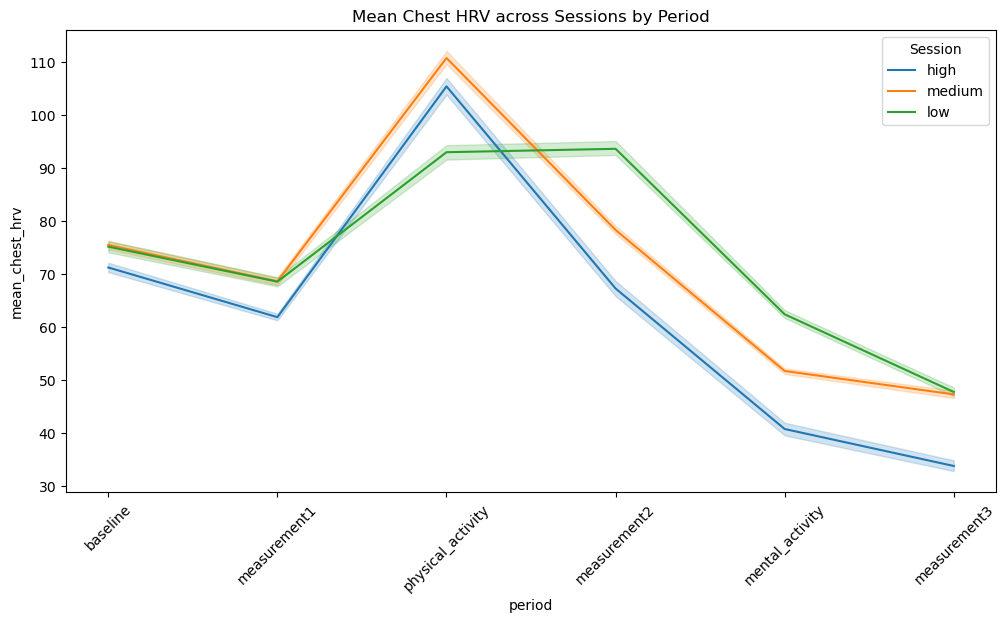

In [56]:

# add a column to interpolated_df equal to the mean chest_hrv over the whole period
interpolated_df['mean_chest_hrv'] = interpolated_df.groupby(['person', 'Session', 'period'])['chest_hrv'].transform('mean')

# change figsize
plt.figure(figsize=(12,6))

# Aggregate means throughout each session by period
sns.lineplot(data=interpolated_df, x='period', y='mean_chest_hrv', hue='Session')
plt.xticks(rotation=45)
plt.title('Mean Chest HRV across Sessions by Period')
plt.show()


#### High Physical Activity Session:
- **Consistently lower mean HRV** throughout each time period when compared to medium physical activity session
  - Lower even before physcial activity starts; could be attributed to expecting a hard workout
- Fastest dropoff of HRV after physical activity is done
- **Decreases to lowest HRV of all sessions** (also doesn't converge with others)

#### Medium Physical Activity Session:
- **During physical activity**, this session has the **highest mean HRV**
- **Converges** with low session at baseline and final measurement (measurement3)

#### Low Physical Activity Session:
- **Smallest increase in mean HRV during physical activity**
- Actually has a slight increase in HRV directly after physical activity, then drops and converges with medium at the final measurement
  - Maybe lower levels of stress / exercise allow the person to maintain a higher HRV for longer?

### Main Ideas:
- Level of physical activity doesn't really affect mean HRV during exercise, they all increase above baseline
- Most sessions HRV falls off monotonically after physical activity
- Exercise, in general, may have a **standardizing effect on HRV**

<hr>

# Metrics Analysis:

## Preprocessing of Metrics Data

Metrics df includes non-time-series data, including performance on tasks and self-reported fatigue scores during each measurement period.

Only one value was null in metrics, so it was replaced with the mean of the feature.

In [57]:
metrics_pre = stack_people_metrics()

print('Nulls:\n')
print(metrics_pre.isnull().sum())

# only null value is right here
rep = metrics_pre['nback_mean_response_time'].mean()
# fill the one null value with hte overall mean in the column
metrics_pre['nback_mean_response_time'] = metrics_pre['nback_mean_response_time'].fillna(rep)

print('\n\nNulls after replacing:\n')
print(metrics_pre.isnull().sum())

print('\nMetrics Dataframe ')

metrics_pre

Nulls:

person                      0
session                     0
period                      0
crt_accuracy                0
crt_mean_response_time      0
nback_mean_response_time    1
nback_accuracy              0
mentalFatigueScore          0
physicalFatigueScore        0
dtype: int64


Nulls after replacing:

person                      0
session                     0
period                      0
crt_accuracy                0
crt_mean_response_time      0
nback_mean_response_time    0
nback_accuracy              0
mentalFatigueScore          0
physicalFatigueScore        0
dtype: int64

Metrics Dataframe 


person session        period  crt_accuracy  crt_mean_response_time  \
0       01     low  measurement1      1.000000                1.847245   
1       01     low  measurement2      1.000000                1.842029   
2       01     low  measurement3      0.972222                1.975534   
3       01  medium  measurement1      1.000000                1.775564   
4       01  medium  measurement2      0.972222                1.727451   
..     ...     ...           ...           ...                     ...   
103     12  medium  measurement2      1.000000                1.672842   
104     12  medium  measurement3      0.944444                1.730509   
105     12    high  measurement1      1.000000                1.640768   
106     12    high  measurement2      1.000000                1.658671   
107     12    high  measurement3      1.000000                1.623908   

     nback_mean_response_time  nback_accuracy  mentalFatigueScore  \
0                    0.794380            0.95           14.166667   
1                    0.629439            0.90           11.250000   
2                    0.759838            1.00           45.833333   
3                    0.556953            0.95           33.472222   
4                    0.570031            1.00           48.333333   
..                        ...             ...                 ...   
103                  0.627568            0.80           62.500000   
104                  0.521879            1.00           74.305556   
105                  0.471239            1.00           37.638889   
106                  0.466274            1.00           36.805556   
107                  0.449143            1.00           32.500000   

     physicalFatigueScore  
0               14.444444  
1               24.027778  
2               20.000000  
3               15.277778  
4               59.166667  
..                    ...  
103             27.083333  
104             21.111111  
105             10.972222  
106             33.750000  
107             26.527778  

[108 rows x 9 columns]

Combine accuracy and response time metrics of the different tests

In [58]:
metrics = metrics_pre.groupby(['person', 'session', 'period'], group_keys=False)[metrics_pre.columns].apply(attach_hrv_to_metrics, obtain_interpolated_df())

# for each row, make a new column of the mean of crt_accuracy and nback_accuracy
metrics['total_accuracy'] = metrics.apply(lambda x: (x['crt_accuracy'] + x['nback_accuracy']) / 2, axis=1)
metrics['total_response_time'] = metrics.apply(lambda x: (x['crt_mean_response_time'] + x['nback_mean_response_time']) / 2, axis=1)

In [59]:
metrics

person session        period  crt_accuracy  crt_mean_response_time  \
0       01     low  measurement1      1.000000                1.847245   
1       01     low  measurement2      1.000000                1.842029   
2       01     low  measurement3      0.972222                1.975534   
3       01  medium  measurement1      1.000000                1.775564   
4       01  medium  measurement2      0.972222                1.727451   
..     ...     ...           ...           ...                     ...   
103     12  medium  measurement2      1.000000                1.672842   
104     12  medium  measurement3      0.944444                1.730509   
105     12    high  measurement1      1.000000                1.640768   
106     12    high  measurement2      1.000000                1.658671   
107     12    high  measurement3      1.000000                1.623908   

     nback_mean_response_time  nback_accuracy  mentalFatigueScore  \
0                    0.794380            0.95           14.166667   
1                    0.629439            0.90           11.250000   
2                    0.759838            1.00           45.833333   
3                    0.556953            0.95           33.472222   
4                    0.570031            1.00           48.333333   
..                        ...             ...                 ...   
103                  0.627568            0.80           62.500000   
104                  0.521879            1.00           74.305556   
105                  0.471239            1.00           37.638889   
106                  0.466274            1.00           36.805556   
107                  0.449143            1.00           32.500000   

     physicalFatigueScore  mean_chest_hrv  total_accuracy  total_response_time  
0               14.444444       56.957854        0.975000             1.320813  
1               24.027778      154.977636        0.950000             1.235734  
2               20.000000       62.437908        0.986111             1.367686  
3               15.277778       63.256410        0.975000             1.166258  
4               59.166667      100.560440        0.986111             1.148741  
..                    ...             ...             ...                  ...  
103             27.083333       72.808511        0.900000             1.150205  
104             21.111111       48.248447        0.972222             1.126194  
105             10.972222       51.509434        1.000000             1.056003  
106             33.750000       85.597990        1.000000             1.062473  
107             26.527778       37.664062        1.000000             1.036525  

[108 rows x 12 columns]

Remember, while interpolated_df has six periods, metrics only has the three measurement periods.

<hr>

### Create a new feature in metrics that is the difference of a person's mean baseline HRV in a given session and their mean HRV for each measurement period in that session.

In [60]:
interpolated_df = obtain_interpolated_df()

baseline_hrv = interpolated_df[interpolated_df['period'] == 'baseline'].groupby(['person', 'Session'])['chest_hrv'].mean().reset_index()
baseline_hrv = baseline_hrv.rename(columns={'chest_hrv': 'baseline_hrv', 'Session': 'session'})

# Merge baseline HRV with metrics
combined_data = pd.merge(metrics, baseline_hrv, on=['person', 'session'])

# display(combined_data)

combined_data['hrv_diff'] = combined_data['mean_chest_hrv'] - combined_data['baseline_hrv']

# Convert period to categorical
combined_data['period'] = pd.Categorical(combined_data['period'], ordered=True)
combined_data['session'] = pd.Categorical(combined_data['session'], ordered=True)


# combined_data['hrv_diff'] = StandardScaler().fit_transform(combined_data['hrv_diff'].values.reshape(-1, 1))

# reorder columns in order person, session, period, hrv_diff, and then everything else
cols_to_move = ['person', 'session', 'period', 'hrv_diff']
remaining_columns = [col for col in combined_data.columns if col not in cols_to_move]

combined_data = combined_data[cols_to_move + remaining_columns]

In [61]:
# Now, combined_data has measurement observations and HRV difference from baseline
combined_data

person session        period    hrv_diff  crt_accuracy  \
0       01     low  measurement1    3.180077      1.000000   
1       01     low  measurement2  101.199858      1.000000   
2       01     low  measurement3    8.660131      0.972222   
3       01  medium  measurement1  -30.271368      1.000000   
4       01  medium  measurement2    7.032662      0.972222   
..     ...     ...           ...         ...           ...   
103     12  medium  measurement2   15.308511      1.000000   
104     12  medium  measurement3   -9.251553      0.944444   
105     12    high  measurement1  -23.179455      1.000000   
106     12    high  measurement2   10.909101      1.000000   
107     12    high  measurement3  -37.024826      1.000000   

     crt_mean_response_time  nback_mean_response_time  nback_accuracy  \
0                  1.847245                  0.794380            0.95   
1                  1.842029                  0.629439            0.90   
2                  1.975534                  0.759838            1.00   
3                  1.775564                  0.556953            0.95   
4                  1.727451                  0.570031            1.00   
..                      ...                       ...             ...   
103                1.672842                  0.627568            0.80   
104                1.730509                  0.521879            1.00   
105                1.640768                  0.471239            1.00   
106                1.658671                  0.466274            1.00   
107                1.623908                  0.449143            1.00   

     mentalFatigueScore  physicalFatigueScore  mean_chest_hrv  total_accuracy  \
0             14.166667             14.444444       56.957854        0.975000   
1             11.250000             24.027778      154.977636        0.950000   
2             45.833333             20.000000       62.437908        0.986111   
3             33.472222             15.277778       63.256410        0.975000   
4             48.333333             59.166667      100.560440        0.986111   
..                  ...                   ...             ...             ...   
103           62.500000             27.083333       72.808511        0.900000   
104           74.305556             21.111111       48.248447        0.972222   
105           37.638889             10.972222       51.509434        1.000000   
106           36.805556             33.750000       85.597990        1.000000   
107           32.500000             26.527778       37.664062        1.000000   

     total_response_time  baseline_hrv  
0               1.320813     53.777778  
1               1.235734     53.777778  
2               1.367686     53.777778  
3               1.166258     93.527778  
4               1.148741     93.527778  
..                   ...           ...  
103             1.150205     57.500000  
104             1.126194     57.500000  
105             1.056003     74.688889  
106             1.062473     74.688889  
107             1.036525     74.688889  

[108 rows x 14 columns]

## Wrap preprocessing into a function:

In [62]:
metrics = obtain_metrics_df()

metrics

person session        period    hrv_diff  crt_accuracy  \
0       01     low  measurement1    3.180077      1.000000   
1       01     low  measurement2  101.199858      1.000000   
2       01     low  measurement3    8.660131      0.972222   
3       01  medium  measurement1  -30.271368      1.000000   
4       01  medium  measurement2    7.032662      0.972222   
..     ...     ...           ...         ...           ...   
103     12  medium  measurement2   15.308511      1.000000   
104     12  medium  measurement3   -9.251553      0.944444   
105     12    high  measurement1  -23.179455      1.000000   
106     12    high  measurement2   10.909101      1.000000   
107     12    high  measurement3  -37.024826      1.000000   

     crt_mean_response_time  nback_mean_response_time  nback_accuracy  \
0                  1.847245                  0.794380            0.95   
1                  1.842029                  0.629439            0.90   
2                  1.975534                  0.759838            1.00   
3                  1.775564                  0.556953            0.95   
4                  1.727451                  0.570031            1.00   
..                      ...                       ...             ...   
103                1.672842                  0.627568            0.80   
104                1.730509                  0.521879            1.00   
105                1.640768                  0.471239            1.00   
106                1.658671                  0.466274            1.00   
107                1.623908                  0.449143            1.00   

     mentalFatigueScore  physicalFatigueScore  mean_chest_hrv  total_accuracy  \
0             14.166667             14.444444       56.957854        0.975000   
1             11.250000             24.027778      154.977636        0.950000   
2             45.833333             20.000000       62.437908        0.986111   
3             33.472222             15.277778       63.256410        0.975000   
4             48.333333             59.166667      100.560440        0.986111   
..                  ...                   ...             ...             ...   
103           62.500000             27.083333       72.808511        0.900000   
104           74.305556             21.111111       48.248447        0.972222   
105           37.638889             10.972222       51.509434        1.000000   
106           36.805556             33.750000       85.597990        1.000000   
107           32.500000             26.527778       37.664062        1.000000   

     total_response_time  baseline_hrv  
0               1.320813     53.777778  
1               1.235734     53.777778  
2               1.367686     53.777778  
3               1.166258     93.527778  
4               1.148741     93.527778  
..                   ...           ...  
103             1.150205     57.500000  
104             1.126194     57.500000  
105             1.056003     74.688889  
106             1.062473     74.688889  
107             1.036525     74.688889  

[108 rows x 14 columns]

<hr>

# Begin Metrics Analysis

                           Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             hrv_diff 
No. Observations:             108                 Method:                         REML     
No. Groups:                   12                  Scale:                          463.2752 
Min. group size:              9                   Log-Likelihood:                 -460.1481
Max. group size:              9                   Converged:                      Yes      
Mean group size:              9.0                                                          
-------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                      -11.186    6.656 -1.681 0.093 -24.231  1.858
C(session)[T.lo

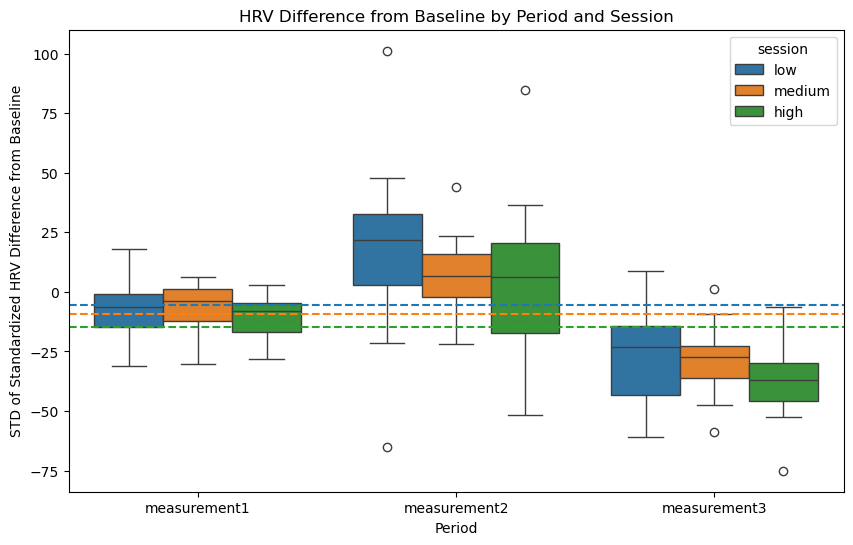

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
  high    low   9.3564 0.3402  -6.4358 25.1485  False
  high medium   5.5593  0.681 -10.2328 21.3514  False
   low medium   -3.797 0.8355 -19.5892 11.9951  False
-----------------------------------------------------

            ---------------------------------------------------------------------------------------------------- 



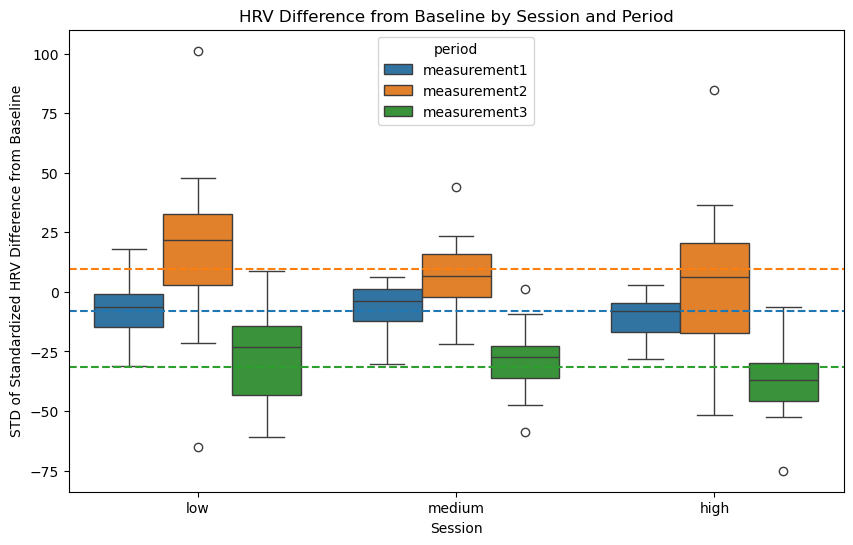

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1       group2    meandiff p-adj   lower    upper   reject
------------------------------------------------------------------
measurement1 measurement2  17.6535  0.004   4.8605  30.4465   True
measurement1 measurement3 -23.2229 0.0001 -36.0159 -10.4299   True
measurement2 measurement3 -40.8764    0.0 -53.6694 -28.0834   True
------------------------------------------------------------------


In [63]:
# import mexedlm
metrics = obtain_metrics_df()

# Perform mixed-effects model analysis
model = mixedlm("hrv_diff ~ C(session) + C(period) + C(session):C(period)", 
                data=metrics, 
                groups="person")
results = model.fit()

print(results.summary())

# conduct anova test



# aov_table = anova_lm(results, typ=2)
# print(aov_table)


print('only p-value less than 0.05 is the interatction between the period variable and the third measurement period.\n')

print('-'*80, '\n')

print('Pairwise Tukey Tests: This test is used to compare all pairs of means.')
print('It is a post-hoc test that is used determine which specific groups differ from each other.')
print('Rejection of the null hypothesis means that the means of the two groups are significantly different from each other.\n\n')






# Visualize the results
plt.figure(figsize=(10, 6))
sns.boxplot(x='period', y='hrv_diff', hue='session', data=metrics)
plt.title('HRV Difference from Baseline by Period and Session')
plt.xlabel('Period')
plt.ylabel('STD of Standardized HRV Difference from Baseline')

# plot a horizontal dotten line in the same color of each session that is the mean over all of the session
for session in ['low', 'medium', 'high']:
    mean = metrics[metrics['session'] == session]['hrv_diff'].mean()
    plt.axhline(mean, color=sns.color_palette()[['low', 'medium', 'high'].index(session)], linestyle='--')


plt.show()

tukey_results = pairwise_tukeyhsd(metrics['hrv_diff'], 
                                  metrics['session'])
print(tukey_results)



# # Additional visualization: HRV change over periods by session
# a = interpolated_df.copy()
# for session in ['low', 'medium', 'high']:
#     baseline = a[(a['period'] == 'baseline') & (a['Session'] == session)]['chest_hrv'].mean()
    
#     p1 = metrics[(metrics['session'] == session) & (metrics['period'] == 'measurement1')]['mean_chest_hrv'].mean()
#     p2 = metrics[(metrics['session'] == session) & (metrics['period'] == 'measurement2')]['mean_chest_hrv'].mean()
#     p3 = metrics[(metrics['session'] == session) & (metrics['period'] == 'measurement3')]['mean_chest_hrv'].mean()

    
    
#     plt.plot([0, 1, 2, 3], [baseline, p1, p2, p3], label=session)

# plt.legend(loc='best')
# plt.ylabel('mean hrv')
# plt.xlabel('Measurement Periods')
# plt.title('Mean HRV by Measurement Period')
# plt.show()

print('\n', '          ', '-'*100, '\n')





# Visualize the results
plt.figure(figsize=(10, 6))
sns.boxplot(x='session', y='hrv_diff', hue='period', data=metrics,
            order=['low', 'medium', 'high'])
plt.title('HRV Difference from Baseline by Session and Period')
plt.xlabel('Session')
plt.ylabel('STD of Standardized HRV Difference from Baseline')

for period in ['measurement1', 'measurement2', 'measurement3']:
    mean = metrics[metrics['period'] == period]['hrv_diff'].mean()
    plt.axhline(mean, color=sns.color_palette()[['measurement1', 'measurement2', 'measurement3'].index(period)], linestyle='--')

plt.show()

tukey_results = pairwise_tukeyhsd(metrics['hrv_diff'], 
                                  metrics['period'])
print(tukey_results)

When aggregating by session, the mean of each **time period** is significantly different.

When aggregatng by period, the mean of each **session** is practically the same.

### Conclusion: HRV changes relative to baseline varied significantly across the course of the experiment, but not the variation is not due to the type of session.

<hr>

## Question: Does a person having lower-than-average HRV in one session, when compared to means of all people in the session, predict that person having lower-than-average HRV in another session?

In [64]:
interpolated_df = obtain_interpolated_df()

# Assuming interpolated_df is your dataframe
# First, let's calculate the mean HRV for each person in each session
person_session_mean = interpolated_df.groupby(['person', 'Session'])['chest_hrv'].mean().unstack()

# Calculate the mean HRV for each session
session_means = person_session_mean.mean()

# Create a boolean DataFrame where True indicates below average HRV
below_average = person_session_mean < session_means

# Calculate the consistency of being below average across sessions
consistency = below_average.sum(axis=1)

# Create a summary DataFrame
summary = pd.DataFrame({
    'low_below_avg': below_average['low'],
    'medium_below_avg': below_average['medium'],
    'high_below_avg': below_average['high'],
    'sessions_below_avg': consistency
})

# Print the summary
display(summary)

# Calculate the correlation between being below average in different sessions
correlation = below_average.corr()
print("\nCorrelation of below-average HRV across sessions:")
display(correlation)

# Count how many people are below average in all sessions
all_below = (consistency == 3).sum()
print(f"\nNumber of people below average in all sessions: {all_below}")

# Count how many people are above average in all sessions
all_above = (consistency == 0).sum()
print(f"Number of people above average in all sessions: {all_above}\n")

print('-'*80, '\n')

print("True means a person's mean HRV during a session IS below the overall mean HRV for that session.\n")

print('-' *80)

# Perform a chi-square test of independence



print('\nSignificance test between low and high sessions:')
contingency_table = pd.crosstab(below_average['low'], below_average['high'])
display(contingency_table)
contingency_table = contingency_table.values

# stat, p_value, dof, expected = chi2_contingency(contingency_table)
# stat, p_value = fisher_exact(contingency_table)
obj = barnard_exact(contingency_table)
stat = obj.statistic
p_value = obj.pvalue

print(f"  Test Statistic: {stat:.4f}")
print(f"  p-value: {p_value:.4f}\n")
print('-'*80)

print('\nSignificance test between low and medium sessions:')
contingency_table = pd.crosstab(below_average['low'], below_average['medium'])
display(contingency_table)
contingency_table = contingency_table.values

# stat, p_value, dof, expected = chi2_contingency(contingency_table)
# stat, p_value = fisher_exact(contingency_table)
obj = barnard_exact(contingency_table)
stat = obj.statistic
p_value = obj.pvalue

print(f"  Test Statistic: {stat:.4f}")
print(f"  p-value: {p_value:.4f}\n")
print('-'*80)

print('\nSignificance test between medium and high sessions:')
contingency_table = pd.crosstab(below_average['medium'], below_average['high'])
display(contingency_table)
contingency_table = contingency_table.values

# stat, p_value, dof, expected = chi2_contingency(contingency_table)
# stat, p_value = fisher_exact(contingency_table)
obj = barnard_exact(contingency_table)
stat = obj.statistic
p_value = obj.pvalue

print(f"  Test Statistic: {stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print('-'*80)

low_below_avg  medium_below_avg  high_below_avg  sessions_below_avg
person                                                                     
01              False             False           False                   0
02              False              True            True                   2
03              False             False            True                   1
04               True              True           False                   2
05               True              True            True                   3
06              False             False           False                   0
07               True              True            True                   3
08               True              True            True                   3
09               True              True            True                   3
10              False             False            True                   1
11              False             False           False                   0
12               True              True           False                   2


Correlation of below-average HRV across sessions:


Session      high       low    medium
Session                              
high     1.000000  0.169031  0.314286
low      0.169031  1.000000  0.845154
medium   0.314286  0.845154  1.000000


Number of people below average in all sessions: 4
Number of people above average in all sessions: 3

-------------------------------------------------------------------------------- 

True means a person's mean HRV during a session IS below the overall mean HRV for that session.

--------------------------------------------------------------------------------

Significance test between low and high sessions:


high   False  True 
low                
False      3      3
True       2      4

  Test Statistic: 0.5855
  p-value: 0.5833

--------------------------------------------------------------------------------

Significance test between low and medium sessions:


medium  False  True 
low                 
False       5      1
True        0      6

  Test Statistic: 2.9277
  p-value: 0.0022

--------------------------------------------------------------------------------

Significance test between medium and high sessions:


high    False  True 
medium              
False       3      2
True        2      5

  Test Statistic: 1.0887
  p-value: 0.3638
--------------------------------------------------------------------------------


#### Which significance test should we use?

The significance test used was **Bardnard's Exact Test**, rather than the more common tests for analyzing contingency tables such as the *Chi-Square Test* and *Fisher's Exact Test*. 

For the Chi-Square Test results to be valid, each cell should have an expected value of 5 or greater, meaning the amount of samples should be 5 x 4 cells, which is 20. However, 12 people is substantially less than the expected number of 20 or greater, which causes problems. **We cannot use the Chi-Square test** if any cell is 0, which is the case in low / medium comparison.

For Fisher's Exact Test results to be valid, the contingency table must have fixed margins, meaning the expected totals of rows and columns must be fixed. This makes sense in a drug study where 25 people are given a placebo and 25 people are given the real drug, however, this assumption does not hold in our case. We cannot know for certain how many people are above or below average, meaning **an assumption does not hold**, so we shouldn't use the test if we have another option.

This leaves **Barnard's Exact Test**. It **does not assume fixed margins**, is **valid at small n values**, and is actually **substantially more powerful than Fisher's Test** for 2x2 tables

### Findings:

Define HRV status as having either an above-average or below-average HRV.

- There is a **non-random relationship between a person's HRV status in the Low Session and that person's HRV status in the Medium Session, even when accounting for Bonferroni correction.** (p=0.0022)
- There is not enough evidence to show that HRV Status significantly differs between Medium and High Sessions or Low and High Sessions.
  
### Interpretation:

One Metabolic Equivalent (MET) is defined as the amount of oxygen consumed while sitting at rest. 

Below are definitions of activities at different intensity levels:
- Low:    1-4 METs

- Medium: 5-8 METs

- High:   8+ METs

The activites selected by the authors of the study were:
- Low: Walking at 5 km/hr (3.2 METs)

- Medium: Jogging at 7 km/hr (5.3 METs)

- High: Jogging at 9 km/hr (8.8 METs)
 
Consider the fact that the selected **Medium and High activities** are very close to the **minimum of their bounds** while the selected **Low activity** is closer to the **maximum of its bounds**.

The difference in METs from Low to Medium intensity is 2.1 while the difference from Medium to High is 3.2, about a 50% increase.

### Conclusion:

#### The significant relationship in HRV status between Low and Medium could be explained by the fact that the difference in energy expenditure in those two sessions is smaller compared to the difference between Medium and High. The comparatively smaller gap in METs between the Low and Medium Sessions may allow for similar recovery patterns, preserving relative HRV status.

<hr>

# Mental Fatigue Statistics

Correlation between HRV and Mental Fatigue Score: -0.32746847407607443


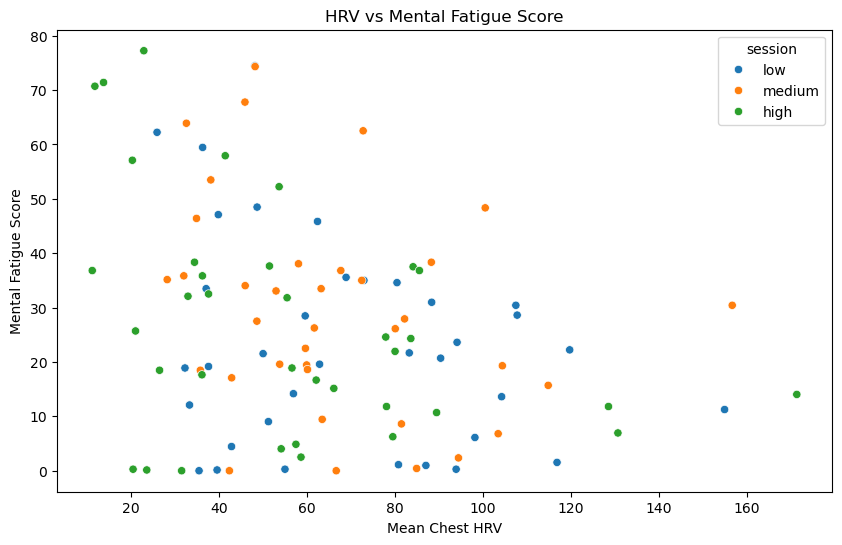

In [65]:
metrics = obtain_metrics_df()

correlation = metrics['mean_chest_hrv'].corr(metrics['mentalFatigueScore'])
print(f"Correlation between HRV and Mental Fatigue Score: {correlation}")

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=metrics, x='mean_chest_hrv', y='mentalFatigueScore', hue='session')
plt.title('HRV vs Mental Fatigue Score')
plt.xlabel('Mean Chest HRV')
plt.ylabel('Mental Fatigue Score')
plt.show()

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
  high    low  -3.4877 0.7371 -14.6113   7.636  False
  high medium   2.5116 0.8534  -8.6121 13.6353  False
   low medium   5.9992 0.4084  -5.1245 17.1229  False
-----------------------------------------------------


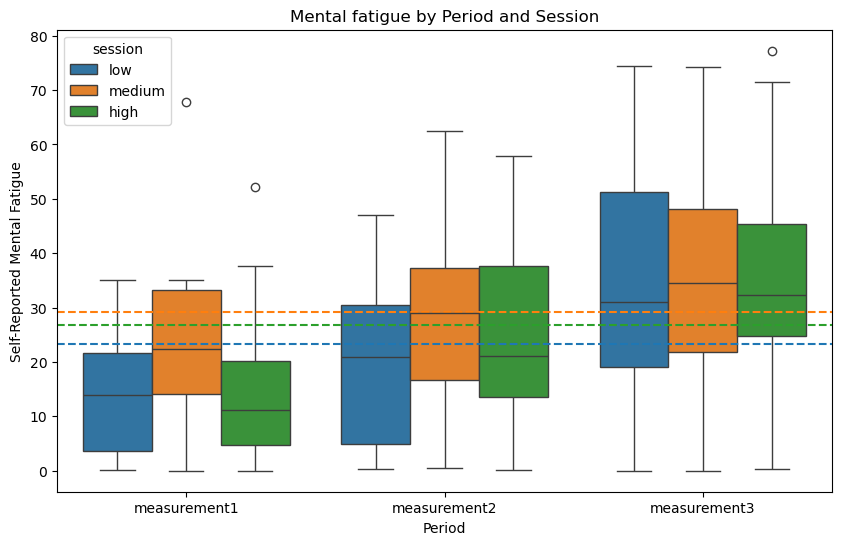

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
measurement1 measurement2   6.1304 0.3421 -4.2433 16.5042  False
measurement1 measurement3  18.0208 0.0002  7.6471 28.3946   True
measurement2 measurement3  11.8904 0.0204  1.5167 22.2642   True
----------------------------------------------------------------


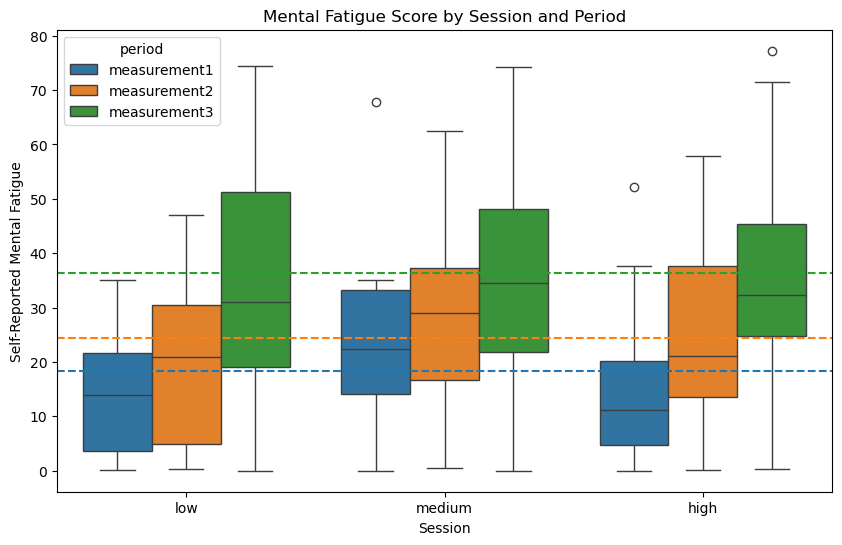

In [66]:
metrics = obtain_metrics_df()

tukey_results = pairwise_tukeyhsd(metrics['mentalFatigueScore'], 
                                  metrics['session'])
print(tukey_results)


# Visualize the results
plt.figure(figsize=(10, 6))
sns.boxplot(x='period', y='mentalFatigueScore', hue='session', data=metrics)
plt.title('Mental fatigue by Period and Session')
plt.xlabel('Period')

for session in ['low', 'medium', 'high']:
    mean = metrics[metrics['session'] == session]['mentalFatigueScore'].mean()
    plt.axhline(mean, color=sns.color_palette()[['low', 'medium', 'high'].index(session)], linestyle='--')


plt.ylabel('Self-Reported Mental Fatigue')
plt.show()

tukey_results = pairwise_tukeyhsd(metrics['mentalFatigueScore'], 
                                  metrics['period'])
print(tukey_results)


plt.figure(figsize=(10, 6))
sns.boxplot(x='session', y='mentalFatigueScore', hue='period', data=metrics)
plt.title('Mental Fatigue Score by Session and Period')
plt.xlabel('Session')
plt.ylabel('Self-Reported Mental Fatigue')

for period in ['measurement1', 'measurement2', 'measurement3']:
    mean = metrics[metrics['period'] == period]['mentalFatigueScore'].mean()
    plt.axhline(mean, color=sns.color_palette()[['measurement1', 'measurement2', 'measurement3'].index(period)], linestyle='--')

plt.show()

#### General Findings:

Mental Fatigue scores were similar when aggregated by session.

However, self-reported levels of mental fatigue in measurement 3 were statistically significant when compared to the earlier periods.

Looking specifically at measurement 1, the medium session Self-Reported Mental Fatigue skewes the mean up by a large factor.

Looking specifically at measurement 3, as physical intensity increases, variability in mental fatigue decreases, but only after the mental fatigue activity.

#### As the original study says, the mental activity portion did induce mental fatigue, which is good.


<hr>

## Statistics from Cognitive Tests during Measurement Periods

Correlation between baseline HRV and n-back accuracy:
r = -0.123, p = 0.474

Correlation between baseline HRV and CRT accuracy:
r = 0.044, p = 0.798


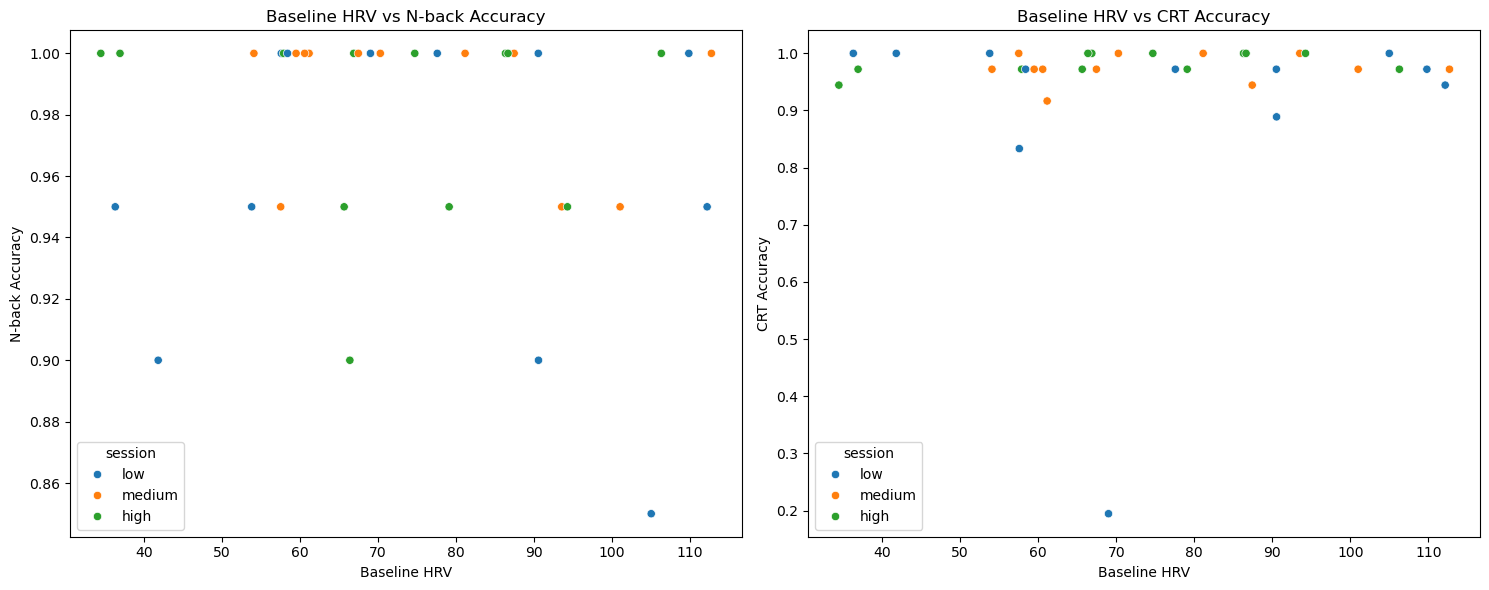

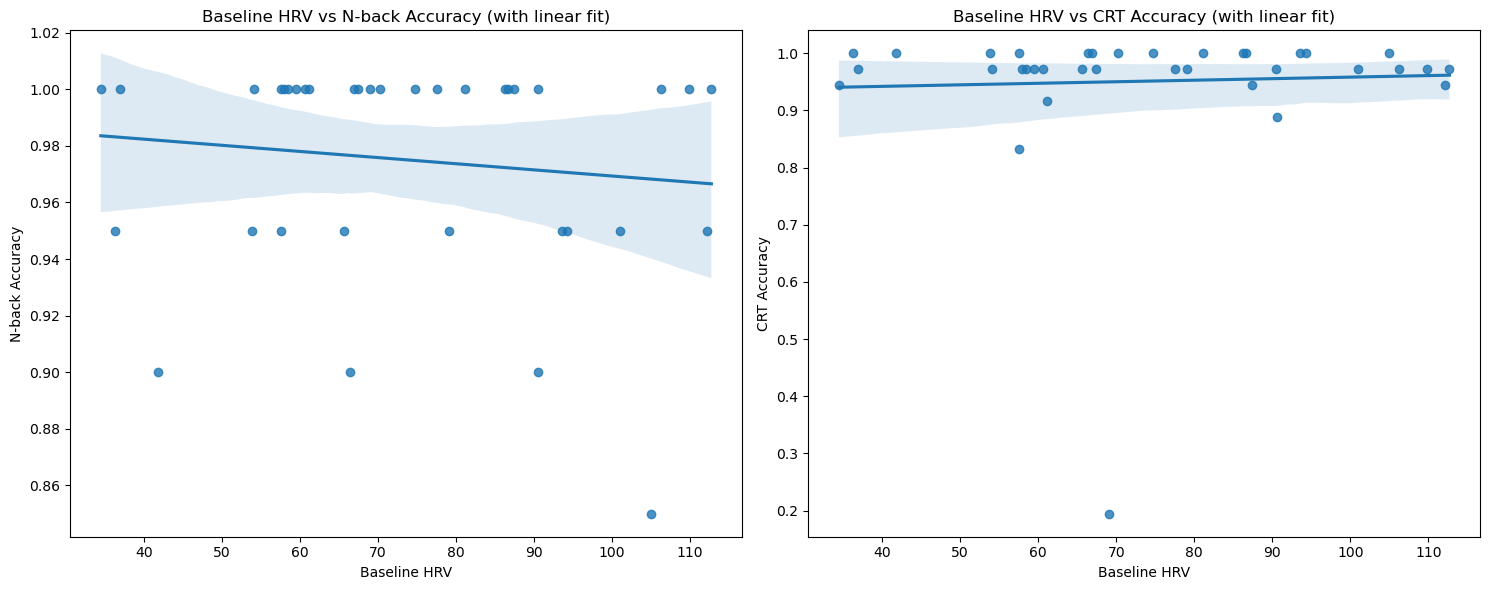

In [67]:
metrics = obtain_metrics_df()

measurement1_data = metrics[metrics['period'] == 'measurement1']

# Calculate correlations
corr_nback = pearsonr(measurement1_data['baseline_hrv'], measurement1_data['nback_accuracy'])
corr_crt = pearsonr(measurement1_data['baseline_hrv'], measurement1_data['crt_accuracy'])

print("Correlation between baseline HRV and n-back accuracy:")
print(f"r = {corr_nback[0]:.3f}, p = {corr_nback[1]:.3f}")

print("\nCorrelation between baseline HRV and CRT accuracy:")
print(f"r = {corr_crt[0]:.3f}, p = {corr_crt[1]:.3f}")

# Visualize the relationships
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(data=measurement1_data, x='baseline_hrv', y='nback_accuracy', hue='session', ax=ax1)
ax1.set_title('Baseline HRV vs N-back Accuracy')
ax1.set_xlabel('Baseline HRV')
ax1.set_ylabel('N-back Accuracy')

sns.scatterplot(data=measurement1_data, x='baseline_hrv', y='crt_accuracy', hue='session', ax=ax2)
ax2.set_title('Baseline HRV vs CRT Accuracy')
ax2.set_xlabel('Baseline HRV')
ax2.set_ylabel('CRT Accuracy')

plt.tight_layout()
plt.show()

# Optional: Check for non-linear relationships
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.regplot(data=measurement1_data, x='baseline_hrv', y='nback_accuracy', order=1, ax=ax1)
ax1.set_title('Baseline HRV vs N-back Accuracy (with linear fit)')
ax1.set_xlabel('Baseline HRV')
ax1.set_ylabel('N-back Accuracy')

sns.regplot(data=measurement1_data, x='baseline_hrv', y='crt_accuracy', order=1, ax=ax2)
ax2.set_title('Baseline HRV vs CRT Accuracy (with linear fit)')
ax2.set_xlabel('Baseline HRV')
ax2.set_ylabel('CRT Accuracy')

plt.tight_layout()
plt.show()


#### Conclusion:
It seems as though the tests were not hard enough, as accuracy is consistenly above 90%. Possibly *because* of this, there is no **significant** correlation between HRV and accuracy in any test.

Something interesting to note is that the plurality of imperfect accuracies in the **low** group.


#### HRV is **not** a good metric to gague accuracy or response time, and visa versa

<hr>

### Note: Important problem with the nback task:

Subject must press a button when the letter they are shown was ALSO shown two slides ago. This means that response_time is tracked ONLY when the person presses the button, telling us nothing about when they correctly or incorrectly DO NOT press it.


<hr>

### Print accuracy by session

In [68]:
# print mean nback accuracy and crt accuracy for each session
print(metrics.groupby('session')['nback_accuracy'].mean())

print('\nall similar', '\n')
print('-'*80)
print('\n')


print(metrics.groupby('session')['crt_accuracy'].mean())

print('\nlow is -outlier', '\n')
print('-'*80)
print('\n')


print(metrics.groupby('session')['nback_mean_response_time'].mean())
print('\nhigh is +outlier', '\n')
print('-'*80)
print('\n')


print(metrics.groupby('session')['crt_mean_response_time'].mean())
print('\nall similar')

session
high      0.983333
low       0.977778
medium    0.984722
Name: nback_accuracy, dtype: float64

all similar 

--------------------------------------------------------------------------------


session
high      0.971451
low       0.939815
medium    0.971451
Name: crt_accuracy, dtype: float64

low is -outlier 

--------------------------------------------------------------------------------


session
high      0.658862
low       0.616978
medium    0.606864
Name: nback_mean_response_time, dtype: float64

high is +outlier 

--------------------------------------------------------------------------------


session
high      1.659459
low       1.654901
medium    1.660073
Name: crt_mean_response_time, dtype: float64

all similar


In [69]:


def perform_anova(df, dv):
    # Two-way ANOVA
    model = ols(f'{dv} ~ (C(session) + C(period) + mean_chest_hrv) ** 2', data=df).fit()
    # model = ols(f'{dv} ~ mean_chest_hrv + C(session) + C(period) + C(session):C(period)', data=df).fit()
    
    anova_table = anova_lm(model, typ=2)
    
    # Pairwise comparisons
    tukey_session = pairwise_tukeyhsd(df[dv], df['session'])
    tukey_period = pairwise_tukeyhsd(df[dv], df['period'])
    
    return anova_table, tukey_session, tukey_period

metrics = obtain_metrics_df()

# List of dependent variables
dependent_vars = ['mentalFatigueScore', 'nback_mean_response_time', 'crt_mean_response_time']

# Perform analyses for each dependent variable
for dv in dependent_vars:
    print(f"\nAnalysis for {dv}")
    anova_result, tukey_session, tukey_period = perform_anova(metrics, dv)
    
    print("\nANOVA Results:")
    print(anova_result)
    
    print("\nTukey HSD for Session:")
    print(tukey_session)
    
    print("\nTukey HSD for Measurement Period:")
    print(tukey_period)

    print('\n', '-'*100, '\n')



Analysis for mentalFatigueScore

ANOVA Results:
                                 sum_sq    df         F    PR(>F)
C(session)                   604.651035   2.0  0.879971  0.418183
C(period)                   3554.805806   2.0  5.173443  0.007387
C(session):C(period)         527.258442   4.0  0.383670  0.819823
mean_chest_hrv              1881.288501   1.0  5.475820  0.021397
C(session):mean_chest_hrv    206.051586   2.0  0.299875  0.741617
C(period):mean_chest_hrv     505.861393   2.0  0.736199  0.481672
Residual                   32294.912301  94.0       NaN       NaN

Tukey HSD for Session:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
  high    low  -3.4877 0.7371 -14.6113   7.636  False
  high medium   2.5116 0.8534  -8.6121 13.6353  False
   low medium   5.9992 0.4084  -5.1245 17.1229  False
-----------------------------------------------------

Tukey HSD for Measur

#### There are no significant differences in accuracy or response time across periods or sessions.

<hr>

# Feature Engeering: HRV Difference from Baseline to Measurement Period

Formula:

```
for each person_session:
        for period in M1, M2, M3:
            hrv_diff = period_mean_hrv - baseline_mean_hrv
```

Plotting of HRV Differences, is described by a Normal Distribution

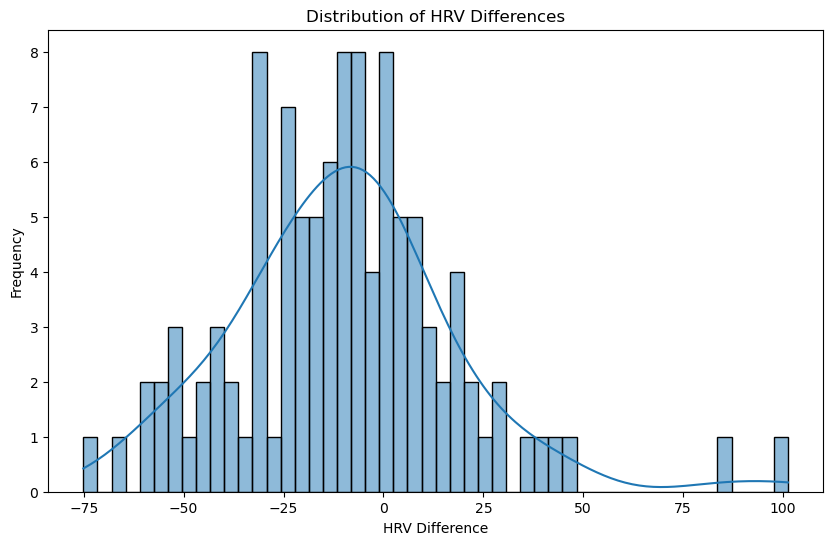

mean is -9.982880355645399
q1 is -26.27683033903951
q3 is 2.995019157088125

Shapiro Statistic: 0.9610, p-value: 0.0030
hrv_diff feature is normally distributed at alpha level 0.05


In [70]:
data = metrics

plt.figure(figsize=(10, 6))
sns.histplot(data['hrv_diff'], kde=True, bins=50)
plt.title('Distribution of HRV Differences')
plt.xlabel('HRV Difference')
plt.ylabel('Frequency')
plt.show()

# get quartiles
q1 = data['hrv_diff'].quantile(0.25)
q3 = data['hrv_diff'].quantile(0.75)

print(f"mean is {data['hrv_diff'].mean()}")
print(f'q1 is {q1}')
print(f'q3 is {q3}')

#groups1
lower = data[data['hrv_diff'] < q1]
middle = data[(data['hrv_diff'] >= q1) & (data['hrv_diff'] <= q3)]
upper = data[data['hrv_diff'] > q3]

norm = shapiro(data['hrv_diff'])

print(f'\nShapiro Statistic: {norm[0]:.4f}, p-value: {norm[1]:.4f}')

print('hrv_diff feature is normally distributed at alpha level 0.05')

Plot boxplots of standard deviations of chest_hrv

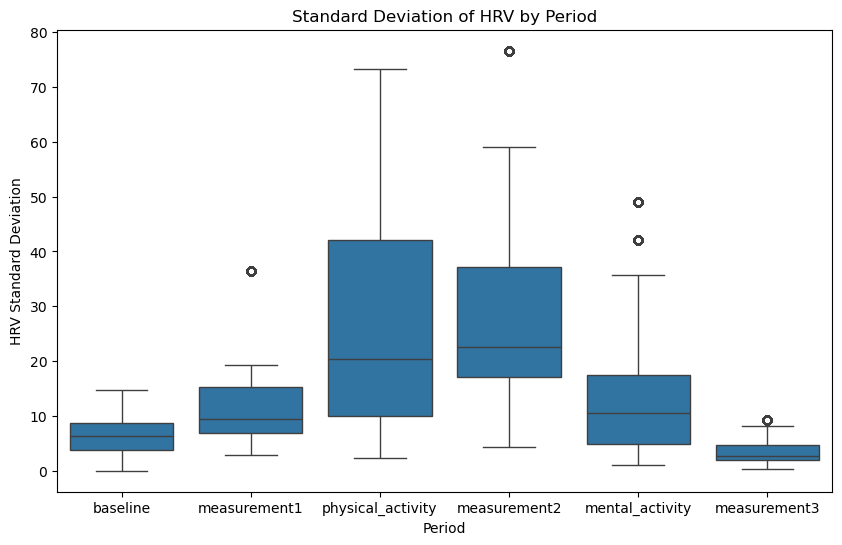

In [71]:
x = obtain_interpolated_df()

# add column called hrv_std that is the standard deviation of the chest_hrv column by person, session, and period
x['hrv_std'] = x.groupby(['person', 'Session', 'period'])['chest_hrv'].transform('std')

# plot the standard deviation of hrv by period
plt.figure(figsize=(10, 6))
sns.boxplot(data=x, x='period', y='hrv_std')
plt.title('Standard Deviation of HRV by Period')
plt.xlabel('Period')
plt.ylabel('HRV Standard Deviation')
plt.show()


Variability of HRV increases towards physical activity and decreases after physical activity. Outliers are also strong from physical_activity to mental_activity, which makes sense as small differences in individuals will be compounded when HRV changes because of activity.

In [72]:
x

person Session        period  chest_hrv   hrv_std
DateTime                                                             
2021-09-02 09:08:19     01    high      baseline       67.0  4.285479
2021-09-02 09:08:20     01    high      baseline       67.0  4.285479
2021-09-02 09:08:21     01    high      baseline       68.0  4.285479
2021-09-02 09:08:22     01    high      baseline       68.0  4.285479
2021-09-02 09:08:23     01    high      baseline       68.0  4.285479
...                    ...     ...           ...        ...       ...
2021-09-09 16:33:54     12     low  measurement3       42.0  3.925121
2021-09-09 16:33:55     12     low  measurement3       42.0  3.925121
2021-09-09 16:33:56     12     low  measurement3       42.0  3.925121
2021-09-09 16:33:57     12     low  measurement3       42.0  3.925121
2021-09-09 16:33:58     12     low  measurement3       42.0  3.925121

[45863 rows x 5 columns]

Plot boxplots of means of data

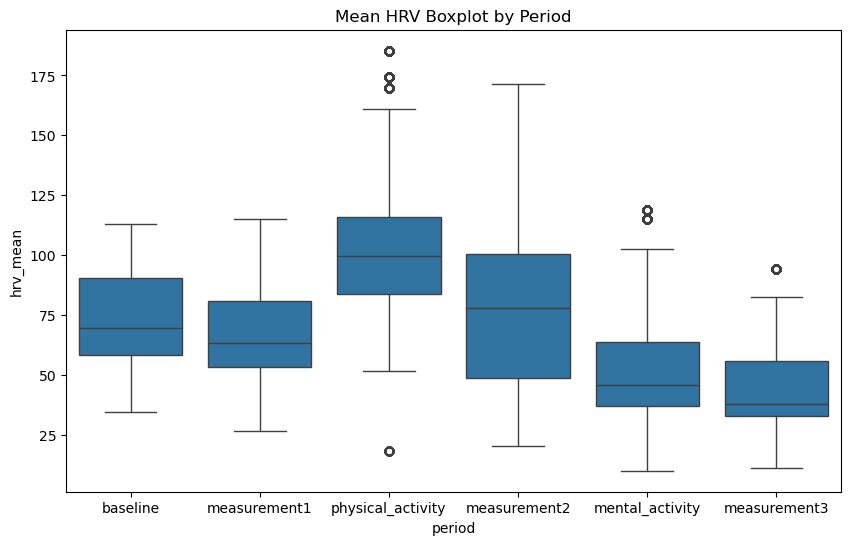

In [73]:
x['hrv_mean'] = x.groupby(['person', 'Session', 'period'])['chest_hrv'].transform('mean')

# plot the mean of hrv by period
plt.figure(figsize=(10, 6))
sns.boxplot(data=x, x='period', y='hrv_mean')
plt.title('Mean HRV Boxplot by Period')
plt.show()

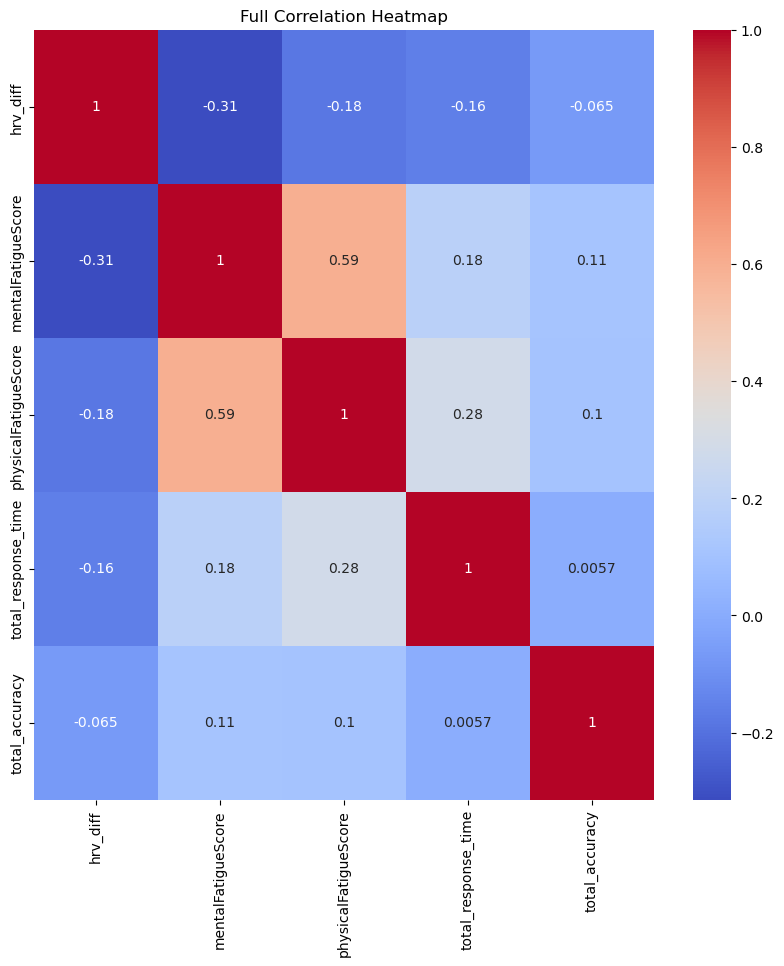

Select only the top row of the heatmap, as we are interested in hrv_diff's correlation with other features:


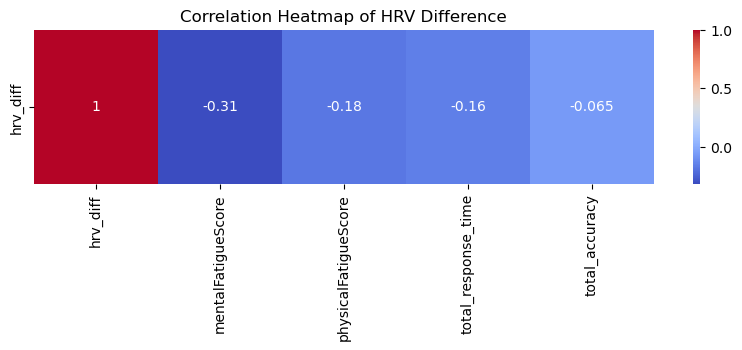

In [74]:
metrics = obtain_metrics_df()

q=metrics[['hrv_diff', 'mentalFatigueScore', 'physicalFatigueScore', 'total_response_time', 'total_accuracy']].corr()
#heatmap
plt.figure(figsize=(10,10))
sns.heatmap(q, annot=True, cmap='coolwarm')
plt.title('Full Correlation Heatmap')
plt.show()

print('Select only the top row of the heatmap, as we are interested in hrv_diff\'s correlation with other features:')


# Only show the top row of the heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(q.iloc[:1], annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of HRV Difference')
plt.show()

## An increase in hrv compared to baseline is correlated with:
- A large decrease in mentalFatigue
- A smaller decrease in physicalFatigue and total response time
- A very small decrease in total_accuracy, which doesn't match up with other bullet points

<hr>

### Lets look into deltas of measurement to baseline and conduct statistical analysis

Define a feature that separates hrv_diff by magnitude for a given threshold, regardless of being positive or negative:

```
df['variation'] == abs( df['hrv_diff'] ) > threshold
```

The Mann Whitney U Test tests, for samples from distributions x in X and y in Y, if prob(X > Y) = prob(Y > X) = 0.5. This compares distributions and central tendencies like mean, median, and mode rather than strictly comparing means.

Lets plot p-values (y-axis, range: 0-1) against thresholds (x-axis, range: 0-100) for different features. Each row represents a dependent variable. The first graph in each row uses all measurement periods in the test, while the next 3 use only measurement1, measurement2, and measurement3, respectively.

___

Note: The Mann Whitney U Test cannot be done when one group is empty, which is why some graphs end early (Example: For measurement period 1, because it is taken immedietly after baseline, HRV from measurement1 is not very different than HRV from baseline, so with a threshold of 50, the "Higher" group is empty).

Note: The first assumption for the test is that the samples are **independent**. This is not exactly the case for this data, as the different measurement periods under the same session are technically dependent on each other. I acknowledge this, yet decided that this is still the best test to see differences in means among groups.


C:\Users\639766\AppData\Local\Temp\ipykernel_52616\3490641997.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['variation'] = abs(df['hrv_diff']) > thr


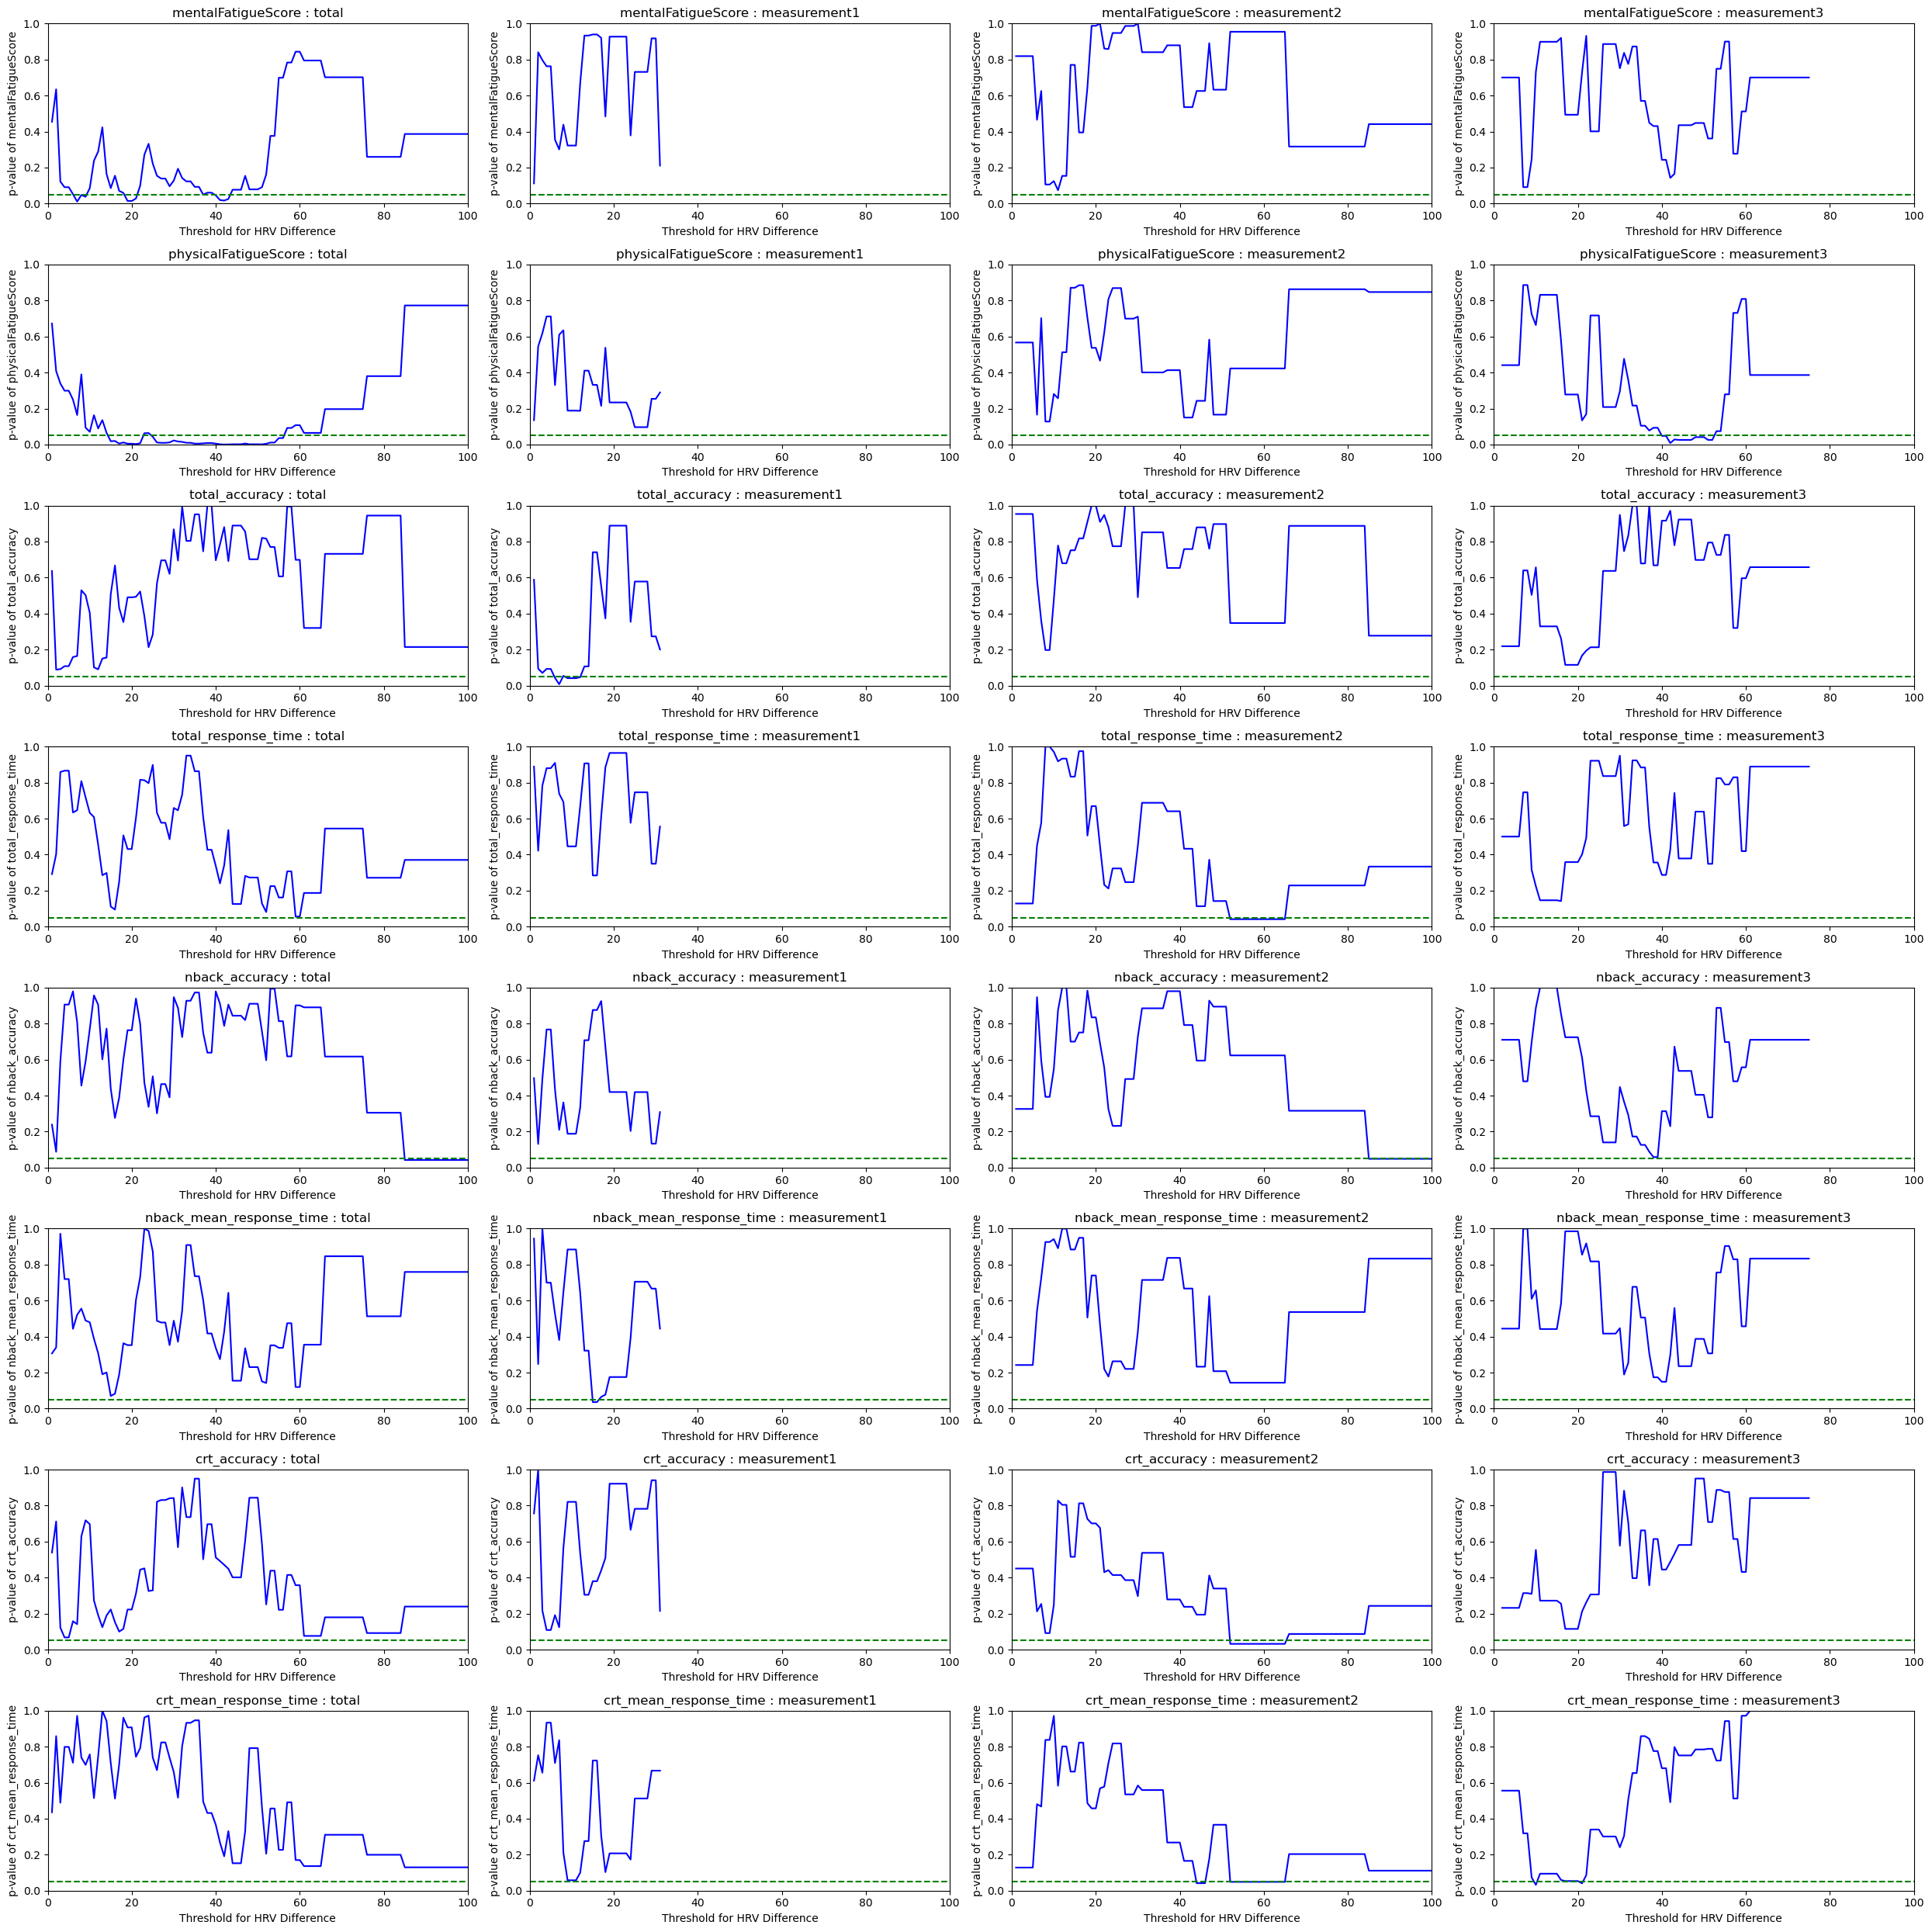

In [75]:
fig, ax = plt.subplots(8, 4, figsize=(25, 25))
metrics = obtain_metrics_df()


for i, feature, in enumerate(['mentalFatigueScore', 'physicalFatigueScore', 'total_accuracy', 'total_response_time', 'nback_accuracy', 'nback_mean_response_time', 'crt_accuracy', 'crt_mean_response_time']):
    for j, period in enumerate(['total', 'measurement1', 'measurement2', 'measurement3']):
        df = None
        if period == 'total':
            df = metrics
        else:
            df = metrics[metrics['period'] == period]


        # For each combination of feature and period, 
        # calculate the Mann-Whitney U test p-value along different thresholds

        pvals = []
        for thr in range(1, 101, 1):
            # print(f'{thr = }')

            # separate into two groups based on the threshold
            df['variation'] = abs(df['hrv_diff']) > thr
            higher_rows = df[(df['variation'] == True)]
            lower_rows = df[(df['variation'] == False)]

            a = higher_rows[feature]
            b = lower_rows[feature]

            if len(a) == 0 or len(b) == 0:
                # Error case, append NaNs
                pvals.append([thr, np.nan, np.nan])
                continue
       
            
            u_stat, p_val = mannwhitneyu(a, b, alternative='two-sided')

            # Calculate rr: effect size
            n1, n2 = len(a), len(b)
            z = (u_stat - (n1 * n2 / 2)) / np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)
            r = z / np.sqrt(n1 + n2)

            pvals.append([thr, p_val, r])

            # # uncomment to print specific p values
            # if feature == 'physicalFatigueScore' and period == 'total' and thr in [18, 19, 25]:
            #     print(f'pval = {p_val} at threshold {thr}')
            # if p_val < 0.00156:
            #     print(f'{feature} at {period} is significant at threshold {thr} with p-value {p_val}')


        ax[i, j].plot([x[0] for x in pvals], [x[1] for x in pvals], color='b')
        
        
        ax[i, j].set_xlabel('Threshold for HRV Difference')
        ax[i, j].set_ylabel(f'p-value of {feature}')
        ax[i, j].set_title(f'{feature} : {period}')

        # p-val significance level
        ax[i, j].axhline(y=0.05, color='g', linestyle='--')

        ax[i, j].set_xlim(0, 100)
        ax[i, j].set_ylim(0, 1)



plt.tight_layout()
plt.show()


## Findings

Note: For each graph, notice that for higher thresholds, the graph looks similar to a step function. This is because there is some threshold that makes one person switch from one group to the next, changing the p value to remain constant until another person changes group at the next relevant threshold.

For tests using all time periods, p-values for mentalFatigueScore and physicalFatigueScore get below 0.05 for some thresholds, however, this is **never** the case for total_accuracy and total_response_time. I am disregarding the graph labeled nback_accuracy : total, as because the p-value is at 0.05 at the highest thresholds, the size of the groups was 107 : 1 (12 people * 3 sessions * 3 measurement periods - 1 : 1), so a p-value under 0.05 is due to that single person having an outlier of the feature. 

For total mental fatigue, p-values are less than 0.05 at (7, 9), (19, 21), 37, and (40, 43).

For total physical fatigue, p-values are less than 0.05 at (15, 22), and (25, 56). 

However, after account for Bonferroni Correction, we notice that only physicalFatigue : total has a significant p-values: (p=0.00028, thr=42; p=0.00077, thr=43)

<hr>

#### Instead of having a threshold over the absolute value of hrv_diff capturing only magnitude, use a threshold of the HRV value itself to capture direction and magnitude.

Formula:

threshold is arbitrary
```
df['variability'] = df['hrv_diff'] > threshold
```

In [76]:
metrics['hrv_diff'].describe()

count    108.000000
mean      -9.982880
std       28.183115
min      -75.085547
25%      -26.276830
50%       -8.782165
75%        2.995019
max      101.199858
Name: hrv_diff, dtype: float64

C:\Users\639766\AppData\Local\Temp\ipykernel_52616\3251805696.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['variation'] = df['hrv_diff'] > thr


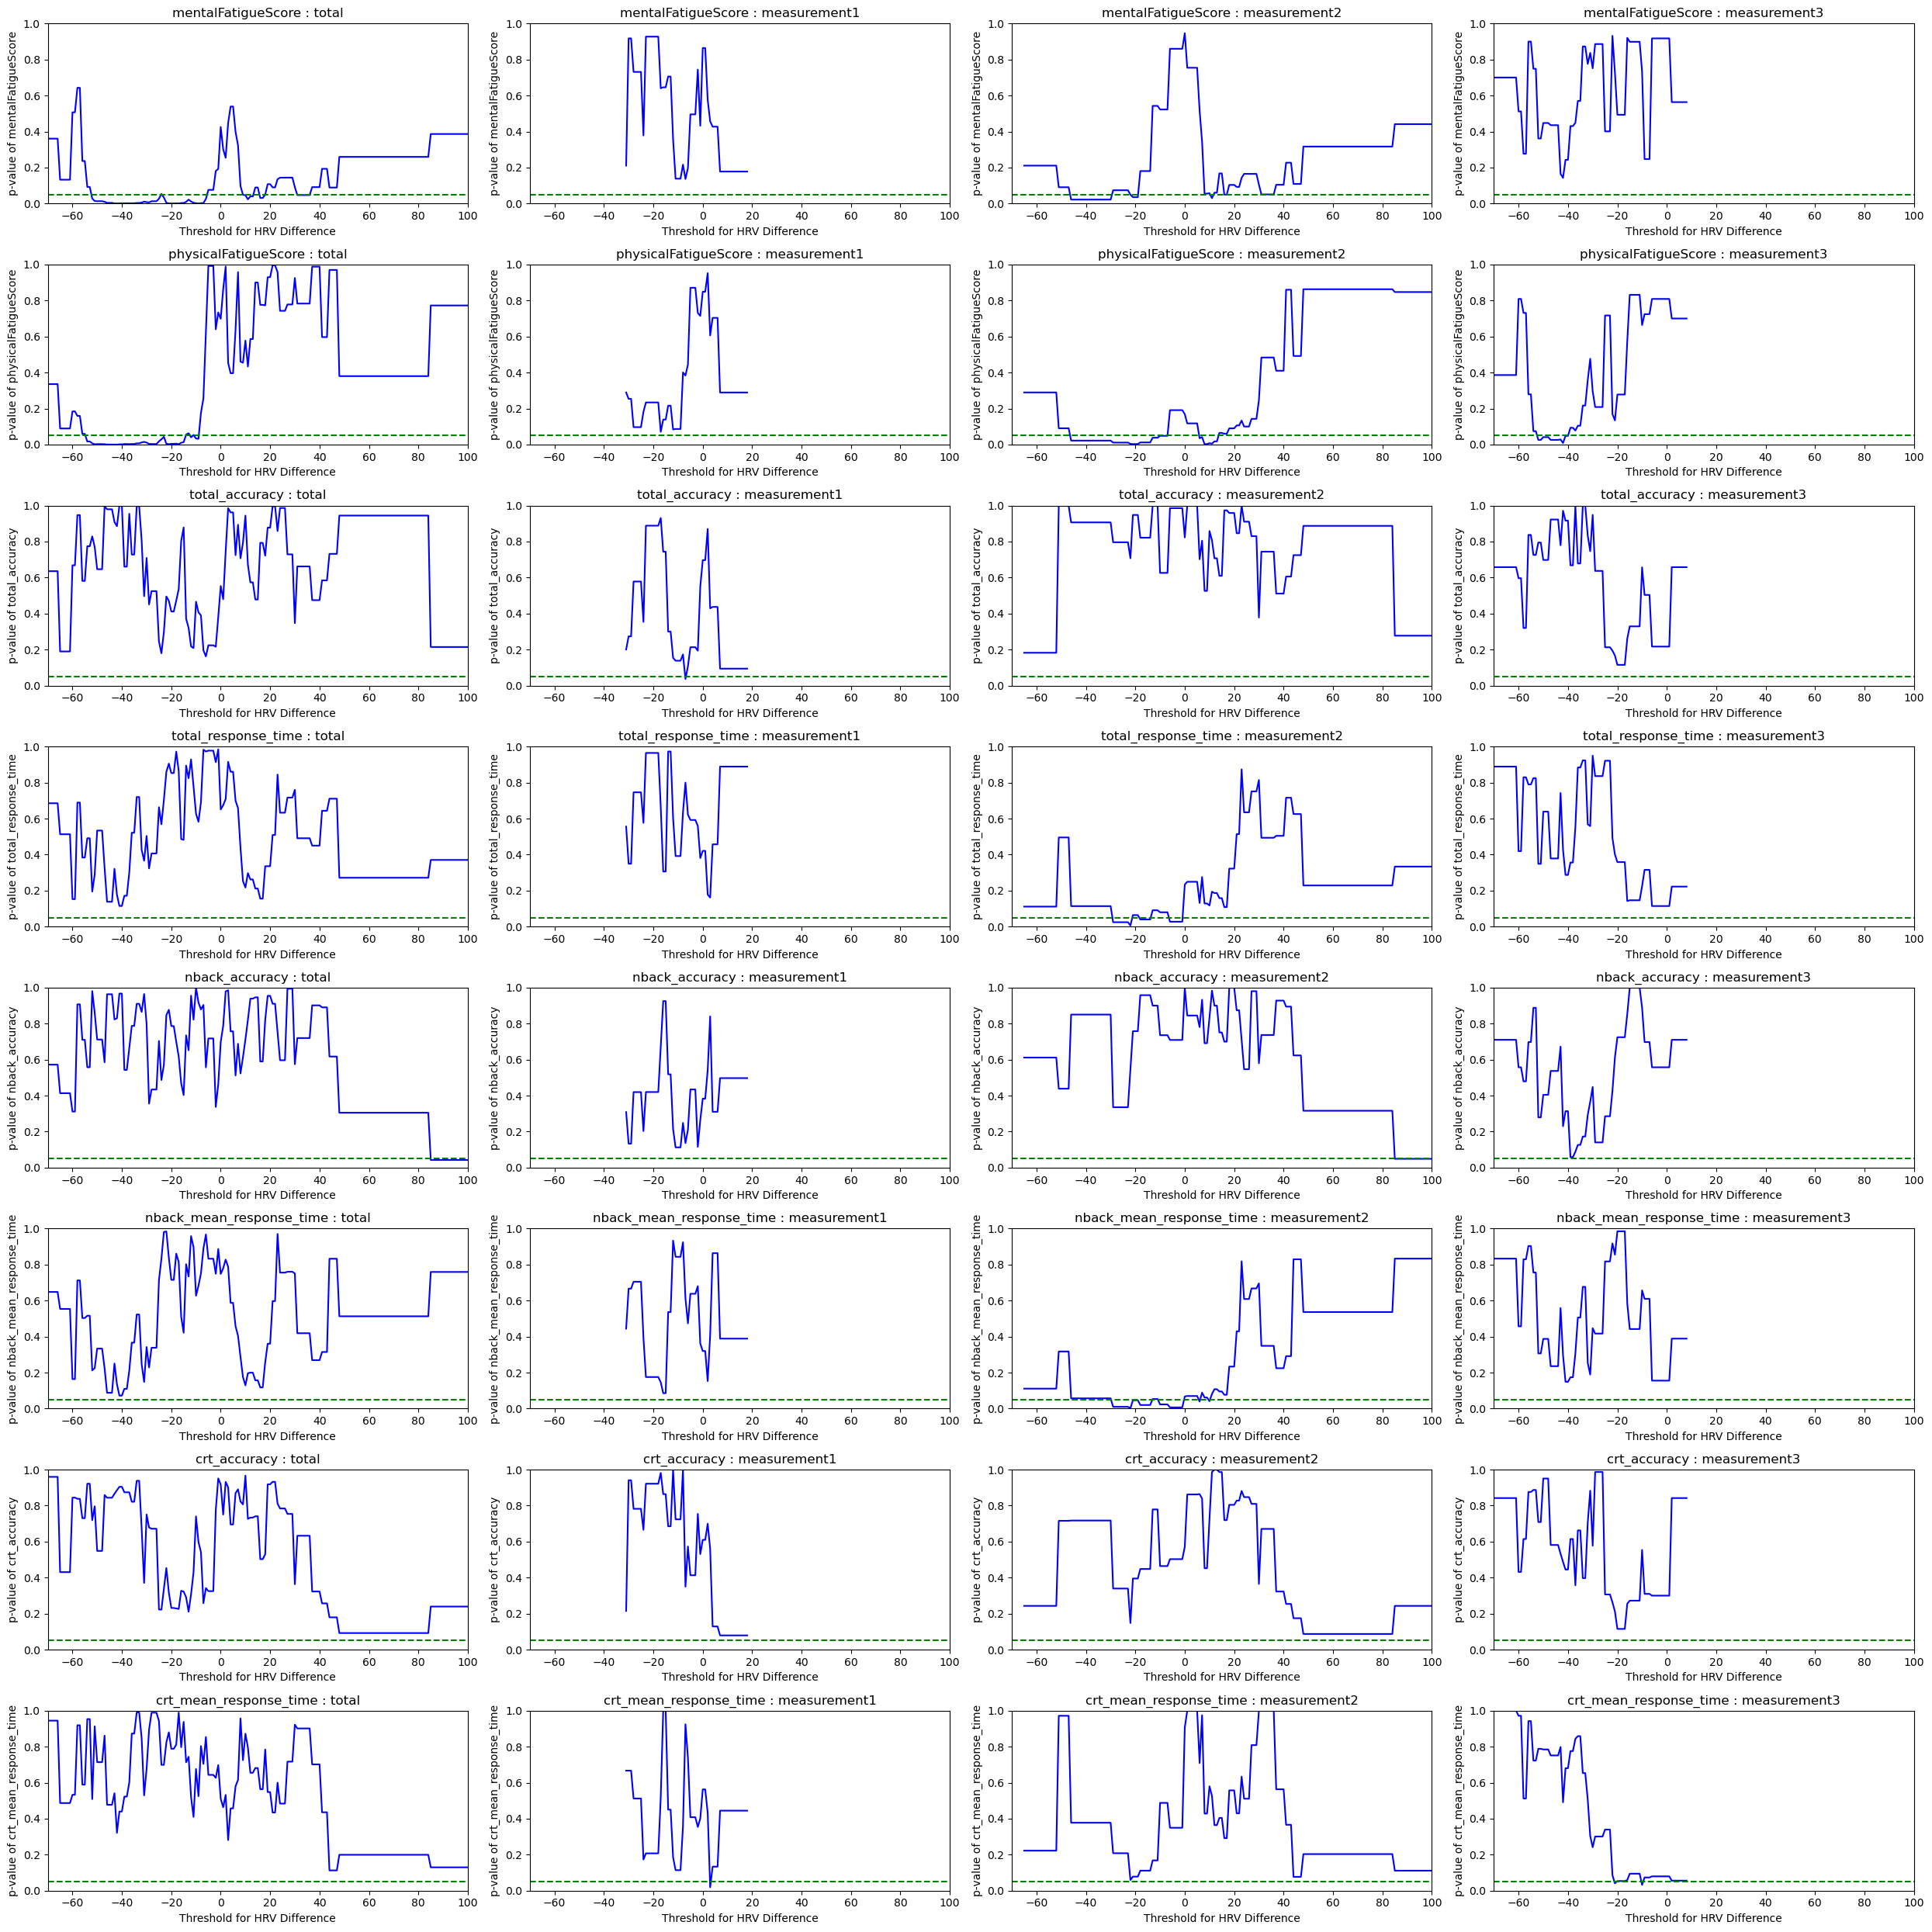

In [77]:
metrics = obtain_metrics_df()

fig, ax = plt.subplots(8, 4, figsize=(25, 25))
for i, feature, in enumerate(['mentalFatigueScore', 'physicalFatigueScore', 'total_accuracy', 'total_response_time', 'nback_accuracy', 'nback_mean_response_time', 'crt_accuracy', 'crt_mean_response_time']):
    for j, period in enumerate(['total', 'measurement1', 'measurement2', 'measurement3']):
        df = None
        if period == 'total':
            df = metrics
        else:
            df = metrics[metrics['period'] == period]

        pvals = []
        for thr in range(int(metrics['hrv_diff'].min()), int(metrics['hrv_diff'].max()+1), 1):
            # print(f'{thr = }')
            df['variation'] = df['hrv_diff'] > thr
            higher_rows = df[(df['variation'] == True)]
            lower_rows = df[(df['variation'] == False)]

            a = higher_rows[feature]
            b = lower_rows[feature]

            if len(a) == 0 or len(b) == 0:
                pvals.append([thr, np.nan, np.nan])
                continue
       
            
            u_stat, p_val = mannwhitneyu(a, b, alternative='two-sided')

            n1, n2 = len(a), len(b)
            z = (u_stat - (n1 * n2 / 2)) / np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)
            r = z / np.sqrt(n1 + n2)

            pvals.append([thr, p_val, r])
            # if thr == -40 and (feature == 'mentalFatigueScore' or feature == 'physicalFatigueScore'):
            #     print(feature)
            #     print(f'{p_val = }')
            #     print(f'{r = }')



        ax[i, j].plot([x[0] for x in pvals], [x[1] for x in pvals], color='b')
        

        # Good threshold area seems to be between 25 and 50, plot vertical lines there
        # plt.axvline(x=30, color='r')
        # plt.axvline(x=50, color='r')
        ax[i, j].set_xlabel('Threshold for HRV Difference')
        ax[i, j].set_ylabel(f'p-value of {feature}')
        ax[i, j].set_title(f'{feature} : {period}')
        # horizontal dotted line at 0.05 green
        # or red if it is below 0.00
        ax[i, j].axhline(y=0.05, color='g', linestyle='--')
        ax[i, j].set_xlim(-70, 100)
        ax[i, j].set_ylim(0, 1)

plt.tight_layout()
plt.show()


For total mental fatigue, p-values are less than 0.05 at: (-52, -6), (9, 13), (16, 18), and (31, 36).

For total physical fatigue, p-values are less than 0.05 at: (-54, -15), -12, -10, and -9.

Because we are running 32 tests, Bonferroni correct sets the new threshold for significance at a / n --> 0.05 / 32 = 0.0016. For both total physical and mental fatigue, p-values reach below this threshold.

- mentalFatigue: p=0.0008, threshold=-43

- physicalFatigue: p=0.0015, threshold=-43

## Interpretation

Recall that in the former group of graphs (deltas), for mental fatigue scores, , we see significant p-values around 40. If the delta metric is truly significant, then in the latter graphs (simple threshold) we should see p-values at 40 **and** -40 to be significant. Instead, we see that only thresholds around **-40** are significant, and actually have lower p-values than. This is also the case for physical fatigue.

## Conclusion

The thresholds taking into account both direction *and* magnitude explain **more** about the data than thresholds taking into account *only* magnitude.

___

## Now, lets examine what the means of the two groups are to see the effect of hrv_diff threshold on self-reported fatigue scores

In [78]:
def cycle():
    # Groups based on ideal threshold, conducts Mann Whitney U on each feature

    print(
        '\n'
    )

    metrics.groupby('variation')['period'].value_counts()

    higher_rows = metrics[metrics['variation'] == True]
    lower_rows = metrics[metrics['variation'] == False]

    features = ['mentalFatigueScore', 'physicalFatigueScore', 'crt_accuracy', 'nback_accuracy']

    for feature in features:
        higher_mean = higher_rows[feature].mean()
        lower_mean = lower_rows[feature].mean()

        feature_mean = metrics[feature].mean()

        print(f'Feature: {feature}')
        std = metrics[feature].std()
        print(f'std = {std:.4f}')
        print(f'Feature mean: {feature_mean:.4f}\n')

        print(f'hrv_diff GREATER_THAN threshold: {higher_mean:.2f}')
        print(f'  diff from mean: {higher_mean - feature_mean:.4f}, {(higher_mean-feature_mean) / std:.4f} stds\n')

        print(f'hrv_diff LESS_THAN threshold:{lower_mean:.4f}')
        print(f'  diff from mean: {lower_mean - feature_mean:.4f}, {(lower_mean-feature_mean) / std:.4f} stds\n')

        
        a = higher_rows[feature]
        b = lower_rows[feature]

        u_stat, p_val = mannwhitneyu(a, b, alternative='two-sided')

        print(f"    Mann Whitney U Test for {feature}:\n")
        print(f"    U Statistic: {u_stat}")
        print(f"    P Value: {p_val}")

        n1, n2 = len(a), len(b)
        
        # formula for z-score calculation
        mean = n1 * n2 / 2
        std = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
        z = (u_stat - mean) / std
        
        # Calculate effect size r
        r = abs(z) / np.sqrt(n1 + n2)

        print(f"    Effect Size r: {r}\n")
        print('================================================\n')

In [79]:
# Later cells show that -43 is the ideal split
threshold = -43


metrics['variation'] = metrics['hrv_diff'] > threshold

print(f'Predetermined ideal threshold is {threshold}')
cycle()

Predetermined ideal threshold is -43


Feature: mentalFatigueScore
std = 19.8193
Feature mean: 26.4108

hrv_diff GREATER_THAN threshold: 23.92
  diff from mean: -2.4929, -0.1258 stds

hrv_diff LESS_THAN threshold:46.3542
  diff from mean: 19.9434, 1.0063 stds

    Mann Whitney U Test for mentalFatigueScore:

    U Statistic: 237.0
    P Value: 0.0009354656308951536
    Effect Size r: 0.31888857144617244


Feature: physicalFatigueScore
std = 18.8088
Feature mean: 23.5288

hrv_diff GREATER_THAN threshold: 21.21
  diff from mean: -2.3222, -0.1235 stds

hrv_diff LESS_THAN threshold:42.1065
  diff from mean: 18.5777, 0.9877 stds

    Mann Whitney U Test for physicalFatigueScore:

    U Statistic: 220.0
    P Value: 0.0005088745382702881
    Effect Size r: 0.33488003373108377


Feature: crt_accuracy
std = 0.0815
Feature mean: 0.9609

hrv_diff GREATER_THAN threshold: 0.96
  diff from mean: -0.0008, -0.0103 stds

hrv_diff LESS_THAN threshold:0.9676
  diff from mean: 0.0067, 0.0820 stds

    Ma

Interestingly, mentalFatigueScore and physicalFatigueScore both had pretty similar means and stds.

## Findings:

When a subject had a HRV during the measurement period < baseline-40, their self-reported physical AND mental fatigue rating was almost a **whole standard deviation above the mean**.

When a subject had a HRV huring the measurement period > baseline-40, their self-reported physical AND mental fatigue rating was **slightly below the mean**.

___

#### Simple Linear Regression model to find correlation:

Mean Squared Error: 374.6036107191774
R-squared: 0.12269800788675445
Coefficient: -0.19736575958467795
Intercept: 24.33641951401372


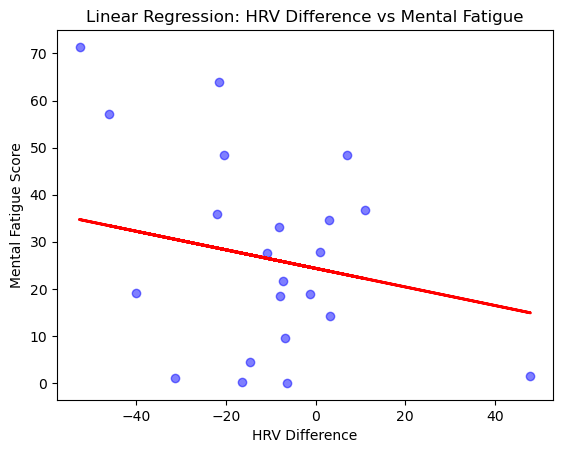

In [80]:
# Prepare your data
X = metrics[['hrv_diff']]  # Independent variable
y = metrics['mentalFatigueScore']  # Dependent variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Coefficient: {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")

# Plot the results
plt.scatter(X_test, y_test, color='blue', alpha=0.5)
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.xlabel('HRV Difference')
plt.ylabel('Mental Fatigue Score')
plt.title('Linear Regression: HRV Difference vs Mental Fatigue')
plt.show()

#### Conduct Linear Regression with combinations of raw mean HRV and (if significantly below threshold or not)

In [81]:
# For each group of dependent variables, find the best threshold that separates into two significantly different
for dependents in [
    ['hrv_diff'],
    ['hrv_diff', 'hrv_threshold'],
    ['hrv_threshold']
]:
    
    print(f'Linear regresssion with dependents: {dependents}')
    
    best_r2 = -np.inf
    best_model = None
    b_t = None
    best_mse = None
    for threshold in range(-90, 60, 1):
        metrics['hrv_threshold'] = (metrics['hrv_diff'] > threshold).astype(int)

        # Prepare your data
        X = metrics[dependents]  # Independent variables
        y = metrics['mentalFatigueScore']  # Dependent variable

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and train the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            b_t = threshold
            best_mse = mse

    print(f"  Mean Squared Error: {best_mse}")
    print(f"  R-squared: {best_r2}")

    print(f"  Coefficients: {model.coef_}")

    print(f"  Intercept: {model.intercept_}")

    print(f'  best threshold is {b_t}\n')


Linear regresssion with dependents: ['hrv_diff']
  Mean Squared Error: 374.6036107191774
  R-squared: 0.12269800788675445
  Coefficients: [-0.19736576]
  Intercept: 24.33641951401372
  best threshold is -90

Linear regresssion with dependents: ['hrv_diff', 'hrv_threshold']
  Mean Squared Error: 331.21081817657324
  R-squared: 0.22432165018934191
  Coefficients: [-0.22336976  9.54623801]
  Intercept: 23.861012744589903
  best threshold is -43

Linear regresssion with dependents: ['hrv_threshold']
  Mean Squared Error: 330.80588267097977
  R-squared: 0.22526998788702857
  Coefficients: [-13.94510582]
  Intercept: 26.583994709202386
  best threshold is -43



Notice the best model just used a binary variable of "is the hrv currently above or below baseline-43" to predict mentalFatigueScore

Notice that while r2 almost doubles from the worst to best model (+84%), MSE only decreases only by about 8%

Keep in mind that MSE of 330 means that Root Mean Scqure Error is 18.16, and because mentalFatigueScore is from 0-100, the best model is 18% off, while the worst model with MSE=374, RMSE=19.3, so 19% off. The difference in model performance was basically negligable.

___

# Main Conclusion from hrv_threshold

### There is a statistically significant differerence in self-reported physical and mental fatigue between groups over or under a certain threshold difference from baseline.

### However, there is not a significant difference in performance on tasks. This verifies the findings of the preliminary results from the dataset article.

Note: Next two cells are copied from the fatigueset paper

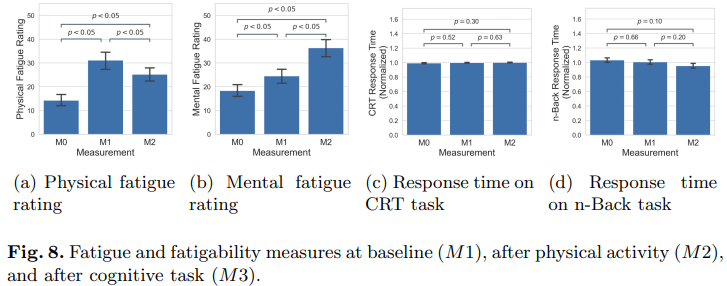

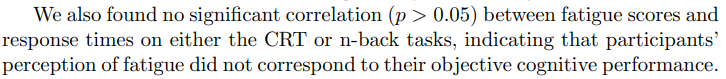

This is further proved by using Linear Regression to predict mentalFatigueScore with the task metrics (accuracy and response time). The r2 value is -0.02, meaning only 2% of the variance in mentalFatigueScore can be explained by the task metrics.

In [82]:
### below basically shows the idea that subjective mental fatigue scores aren't correlated with performance metrics

# fit simple linear regression to estimate mentalFatigueScore


metrics = obtain_metrics_df()

metrics['session'] = metrics['session'].map({'low': 0, 'medium': 1, 'high': 2})

X = metrics[['crt_accuracy', 'crt_mean_response_time', 'nback_mean_response_time', 'nback_accuracy']]
y = metrics['mentalFatigueScore']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

print(
    f'Mean squared error: {mean_squared_error(y_test, y_pred)}\n'
    f'R2 score: {r2_score(y_test, y_pred)}'
)


Mean squared error: 438.516523466179
R2 score: -0.0269826787650842


<hr>

# Does adding pre-session self-reported metrics such as sleepiness or alertness affect the regression model?

Subjects were asked multiple questions about how they felt on the day of their session, including "How sleepy do you feel" and other similar questions.

Preprocess pre_task_survey.xlsx

Note: Column names are self-explanatory except for "much," where the question is "How much of an effort is it to do anything?"

In [83]:
metrics = obtain_metrics_df()
metrics['person'] = metrics['person'].astype(int)
mf = metrics[['person', 'session', 'period', 'mentalFatigueScore', 'mean_chest_hrv', 'hrv_diff']]

path = os.path.join(FATIGUESET_DIRECTORY, 'pre_task_survey.xlsx')
pretask = pd.read_excel(path, parse_dates=['Start time'])

# only grab values I think will be relevant for analysis
features = ['person', 'session', 'st', 'et']

# column names other than id session start time and completion time are too long. Replace them with the second word in the column name
for col in pretask.columns:
    if col in ['ID', 'Session', 'Start time', 'Completion time']:
        continue
    else:
        features.append(col.split()[1])
pretask.columns = features
pretask.drop(columns=['st', 'et'], inplace=True)

# indicate: need to change text to numbers, dropping for now
pretask.drop(columns=['indicate'], inplace=True)


# remap int sessions to low med high
pretask['session'] = pretask['session'].map({1: 'low', 2: 'medium', 3: 'high'})


# attach pretask to metrics by person and session
combined = pd.merge(mf, pretask, on=['person', 'session'])

display(combined)

person session        period  mentalFatigueScore  mean_chest_hrv  \
0         1     low  measurement1           14.166667       56.957854   
1         1     low  measurement2           11.250000      154.977636   
2         1     low  measurement3           45.833333       62.437908   
3         1  medium  measurement1           33.472222       63.256410   
4         1  medium  measurement2           48.333333      100.560440   
..      ...     ...           ...                 ...             ...   
103      12  medium  measurement2           62.500000       72.808511   
104      12  medium  measurement3           74.305556       48.248447   
105      12    high  measurement1           37.638889       51.509434   
106      12    high  measurement2           36.805556       85.597990   
107      12    high  measurement3           32.500000       37.664062   

       hrv_diff  alert  sad  tense  much  happy  weary  calm  sleepy  
0      3.180077      8    0      0     5      6      4     8       3  
1    101.199858      8    0      0     5      6      4     8       3  
2      8.660131      8    0      0     5      6      4     8       3  
3    -30.271368      7    0      1     3      7      3     2       4  
4      7.032662      7    0      1     3      7      3     2       4  
..          ...    ...  ...    ...   ...    ...    ...   ...     ...  
103   15.308511      8    3      3     2      8      3     7       1  
104   -9.251553      8    3      3     2      8      3     7       1  
105  -23.179455      8    2      4     3      7      4     6       2  
106   10.909101      8    2      4     3      7      4     6       2  
107  -37.024826      8    2      4     3      7      4     6       2  

[108 rows x 14 columns]

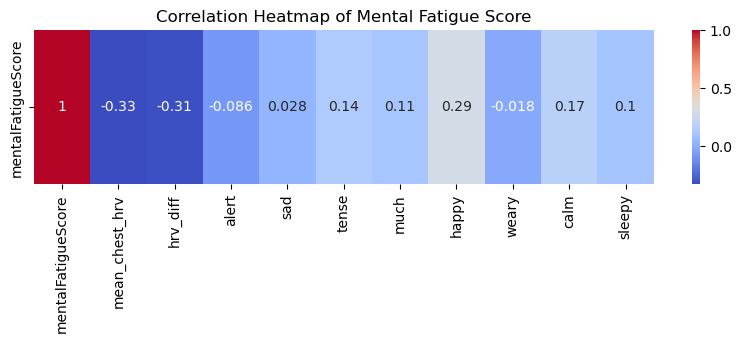

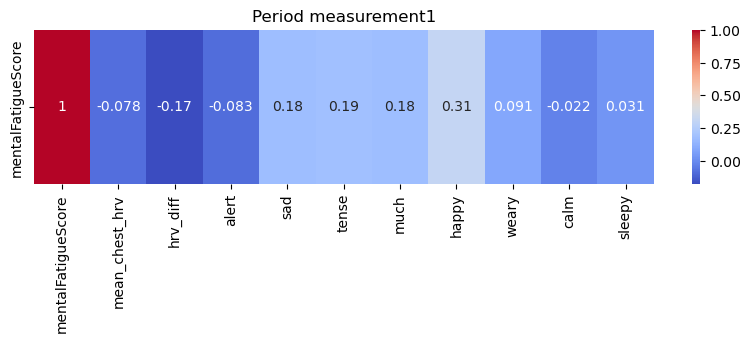

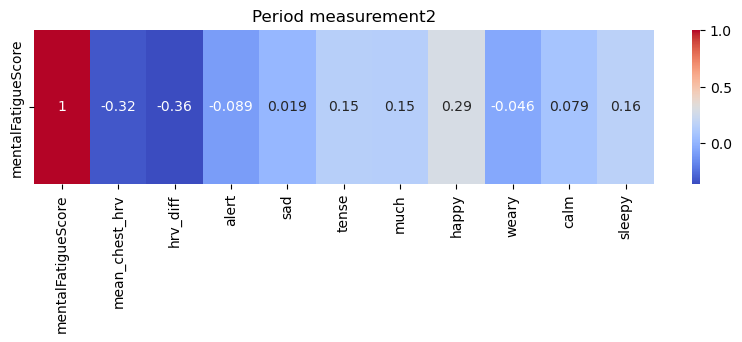

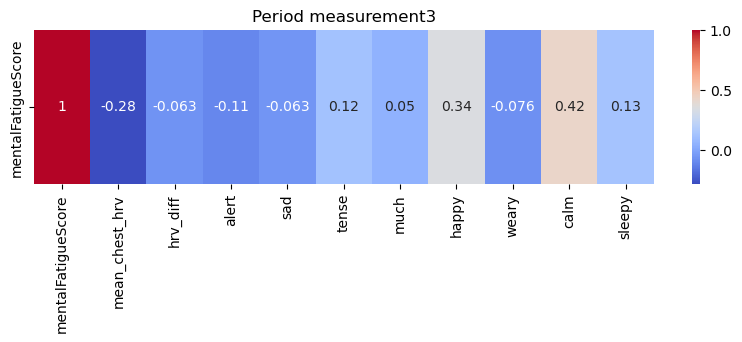

In [84]:
# correlation heatmap between meantalFatigueScore and all added columns
q = combined
q = q.drop(columns=['person', 'session', 'period']).corr()
plt.figure(figsize=(10, 2))
sns.heatmap(q['mentalFatigueScore'].to_frame().T, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Mental Fatigue Score')
plt.show()

for period in ['measurement1', 'measurement2', 'measurement3']:
    q = combined
    q = q[q['period'] == period]
    q = q.drop(columns=['person', 'session', 'period']).corr()
    plt.figure(figsize=(10, 2))
    sns.heatmap(q['mentalFatigueScore'].to_frame().T, annot=True, cmap='coolwarm')
    plt.title(f'Period {period}')
    plt.show()

## Findings:

Over all time periods, higher mental fatigue scores are strongly correlated with happiness and weakly correlated with sleepiness, calmness, tenseness, and the rating of "ability to do anything."

Maybe when people are happier, they are less excited to go through the study, resulting in higher mental fatigue scores.

In [85]:
combined.drop(columns=['person', 'session', 'period']).describe()

mentalFatigueScore  mean_chest_hrv    hrv_diff       alert         sad  \
count          108.000000      108.000000  108.000000  108.000000  108.000000   
mean            26.410751       64.020360   -9.982880    8.027778    1.277778   
std             19.819282       31.873734   28.183115    1.122900    1.509059   
min              0.000000       11.225564  -75.085547    4.000000    0.000000   
25%             11.666667       38.047402  -26.276830    7.750000    0.000000   
50%             23.055556       59.156667   -8.782165    8.000000    1.000000   
75%             36.076389       83.383193    2.995019    9.000000    2.000000   
max             77.222222      171.394030  101.199858   10.000000    7.000000   

            tense        much       happy       weary        calm      sleepy  
count  108.000000  108.000000  108.000000  108.000000  108.000000  108.000000  
mean     2.472222    3.000000    6.527778    2.666667    6.694444    2.083333  
std      1.856830    2.157361    1.430367    1.707597    1.769198    1.713743  
min      0.000000    0.000000    3.000000    0.000000    2.000000    0.000000  
25%      1.000000    1.750000    5.750000    2.000000    6.000000    1.000000  
50%      2.000000    2.500000    7.000000    2.000000    7.000000    2.000000  
75%      4.000000    5.000000    7.000000    3.250000    8.000000    3.000000  
max      7.000000    7.000000    9.000000    7.000000   10.000000    6.000000

___

Lets see what happens when we add the highly correlated features to the Linear Regression model.

In [86]:
combined

person session        period  mentalFatigueScore  mean_chest_hrv  \
0         1     low  measurement1           14.166667       56.957854   
1         1     low  measurement2           11.250000      154.977636   
2         1     low  measurement3           45.833333       62.437908   
3         1  medium  measurement1           33.472222       63.256410   
4         1  medium  measurement2           48.333333      100.560440   
..      ...     ...           ...                 ...             ...   
103      12  medium  measurement2           62.500000       72.808511   
104      12  medium  measurement3           74.305556       48.248447   
105      12    high  measurement1           37.638889       51.509434   
106      12    high  measurement2           36.805556       85.597990   
107      12    high  measurement3           32.500000       37.664062   

       hrv_diff  alert  sad  tense  much  happy  weary  calm  sleepy  
0      3.180077      8    0      0     5      6      4     8       3  
1    101.199858      8    0      0     5      6      4     8       3  
2      8.660131      8    0      0     5      6      4     8       3  
3    -30.271368      7    0      1     3      7      3     2       4  
4      7.032662      7    0      1     3      7      3     2       4  
..          ...    ...  ...    ...   ...    ...    ...   ...     ...  
103   15.308511      8    3      3     2      8      3     7       1  
104   -9.251553      8    3      3     2      8      3     7       1  
105  -23.179455      8    2      4     3      7      4     6       2  
106   10.909101      8    2      4     3      7      4     6       2  
107  -37.024826      8    2      4     3      7      4     6       2  

[108 rows x 14 columns]

Print r2 when new model's r2 exceeds old model

In [87]:
data = combined

dependents_list = ['hrv_diff', 'hrv_threshold', 'alert', 'sad', 'tense', 'much', 'happy', 'weary', 'calm', 'sleepy']

# iterate through all combinations of any length

best_r2 = float('-inf')
best_model = None
b_t = None
best_mse = None
best_deps = None
for i in range (1, len(dependents_list)):
    for dependents in combinations(dependents_list, i):
        dependents = list(dependents)
        #to list
    
        # print(f'Linear regresssion with dependents: {dependents}')

        # already know optimal threshold is -43
        threshold = -43

        combined['hrv_threshold'] = (combined['hrv_diff'] > threshold).astype(int)

        # Prepare your data
        X = data[dependents]  # Independent variables
        y = data['mentalFatigueScore']  # Dependent variable

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and train the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if r2 > best_r2:
            print(f'update to {r2}')
            print(f'mse = {mse}')
            print(f'vars: {dependents}\n')
            best_r2 = r2
            best_model = model
            b_t = threshold
            best_mse = mse
            best_deps = dependents

print(f"  Mean Squared Error: {best_mse}")
print(f"  R-squared: {best_r2}")

print(f"  Coefficients: {model.coef_}")

print(f"  Intercept: {model.intercept_}")

print(f'  best threshold is {b_t}\n')

print(f'  best dependent list is:\n{best_deps}')


update to 0.12269800788675445
mse = 374.6036107191774
vars: ['hrv_diff']

update to 0.22526998788702857
mse = 330.80588267097977
vars: ['hrv_threshold']

update to 0.25881268548530956
mse = 316.483316728424
vars: ['hrv_diff', 'happy']

update to 0.36465857236213106
mse = 271.2876466395856
vars: ['hrv_threshold', 'happy']

update to 0.425946397735662
mse = 245.1180483889897
vars: ['hrv_threshold', 'alert', 'happy']

update to 0.4312716270271081
mse = 242.8442018248459
vars: ['hrv_threshold', 'alert', 'happy', 'weary']

update to 0.43303528200760366
mse = 242.09112987277487
vars: ['hrv_threshold', 'alert', 'happy', 'calm']

update to 0.4353917810143685
mse = 241.08491645421884
vars: ['hrv_threshold', 'alert', 'happy', 'weary', 'calm']

update to 0.435481642413179
mse = 241.04654608146092
vars: ['hrv_threshold', 'alert', 'sad', 'happy', 'weary', 'calm']

  Mean Squared Error: 241.04654608146092
  R-squared: 0.435481642413179
  Coefficients: [-20.23273631  -3.4409377   -0.60076478   0.9795

Recall that the metrics for dependents = [hrv_threshold]:

  Mean Squared Error: 330.80588267097977
  
  R-squared: 0.22526998788702857

While 6 variables technically had the highest r2 value of 0.435 (MSE = 241.0), 3 variables (hrv_threshold, alertness, and happiness) are able to achieve a r2 value of 0.425 (MSE = 245.1), a difference of 1% of r2.

We were able to increase r2 by 88% and decrease MSE by 34% with the addition of the alertness and happiness features.

___

# Final Notebook Conclusions:

<br>

### Regarding Dataset Study Protocol:

- The different time periods in the study (baseline period, physical and mental activity periods, and measurement periods) were not long enough to allow a full analysis of a person's HRV as different conditions are applied and removed.

### Aggregated HRV by Session and Period Visuals:

- While baseline, M1, and M3 mean HRV for Low and Medium sessions was exactly the same, the High session exhibited a lower HRV, even in the periods before physical activity (which is the only difference between sessions). The study did not explicitly say if / when subjects knew which physical intensity level they were doing in the moment. However, the deviation could be due to subjects expecting a harder workout, which could lead the sympathetic to lower HRV for the fight-or-flight response.

- M2 Low session HRV increased from physical activity into M2. People exhibit higher HRV in less-stressful situations as the parasympathetic system becomes more active. Because the physical activity prescribed for the Low session is only walking, this could be why we see a slight increase in HRV after physical activity.

- The strongest decline in HRV after physical activity was in the High intensity period, dropping HRV to well below baseline levels.

- HRV varied over the course of the experiment due to the introduction of physical and mental activity sessions. However, there is not a strong correlation between the session type and mean HRV across the whole session.

### Significance Testing:

- Barnard's Exact Test showed that those that have a below-average HRV difference from baseline in the Low Session continue to have a below-average HRV difference from baseline in the Medium Session. The finding does not follow for Low and High Sessions, or Medium and High Sessions. We see this most likely because the difference in energy expenditure between Low and Medium sessions is much smaller compared to the difference between Medium and High sessions. In a future study, consider making the different exercises an equal difference apart in terms of METs

- **Findings from the fatigueset paper were replicated. The data from fatigueset is not comprehensive enough to prove a significant relationship between self-reported mental fatigue scores and performance on tasks during measurement periods.**

  - Mean self-reported levels of mental fatigue in measurement period 3 were statistically significant when compared to earlier periods (low : high, p=0.0002; medium : high, p=0.0204). This means we could predict if mental fatigue scores should increase or decrease by determining if mental activity was done prior to the measurement. However, the relevance is limited if there isn't a relationship between actual cognitive performance and people's perception of their performance, which is what the dataset exemplifies.

  - The variability in accuracy and response time of tasks was not high enough to be able to be correlated with HRV, as well as with the self-reported scores. In a future study, there should be more variability in these metrics, meaning we seek more difficult tests. This would allow us to determine if there actually is a correlatation between self-reported scores and cognitive performance.
  
  - There is a statistically significant difference in self-reported physical (U=220.0, p=0.0005) and mental fatigue (U=237.0, 0.0009) between groups over or under a certain threshold of HRV difference from baseline. However, there is not a significant difference in performance on tasks. This verifies the findings of the preliminary results from the dataset article.

### Modeling HRV and Fatigue Interaction

- Increase in hrv_diff feature (difference between current mean HRV and baseline mean HRV) is correlated with a decrease in self-reported mental fatigue, self-reported physical fatigue, and total_response_time.

- A threshold separating hrv_diff by direction and magnitude is better for predicting self-reported physical and mental scores than a threshold separating only by magnitude.

- Using hrv_threshold over hrv_diff almost doubled r2 metric. Using happiness and alertness scores with hrv_threshold resulted in another r2 doubling.

In conclusion, the preliminary findings of the Fatiguset paper were verified, but the lack of relationship between one's own performance and perception of performance could be due to problems in the study protocol. A future study should incorporate longer time periods to better distinguish between features that come from the *transition between time periods* as opposed to the *current time period itself*. It should also use more difficult tests to obtain metrics with higher variability to better correlate accuracy or response time with other features.

<hr>

<hr>